In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib
import pickle
from matplotlib import cm
from tqdm import tqdm
import scipy.stats as stats
import seaborn as sns

In [2]:
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True) # Turn off tqdm for a clean display 

In [3]:
import os
os.chdir("..")
plt.style.use('plot_style.txt')
fig_save_path = os.path.join(os.path.abspath(os.curdir), "Simulation", 'figures')

In [4]:
import VPSModeling.Network as net

In [5]:
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])


plt.rc('axes',prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [6]:
s1=5.1667 / 1.0
s2=5.1667 / 1.5
a_scale=100
iscale = 2*1.3

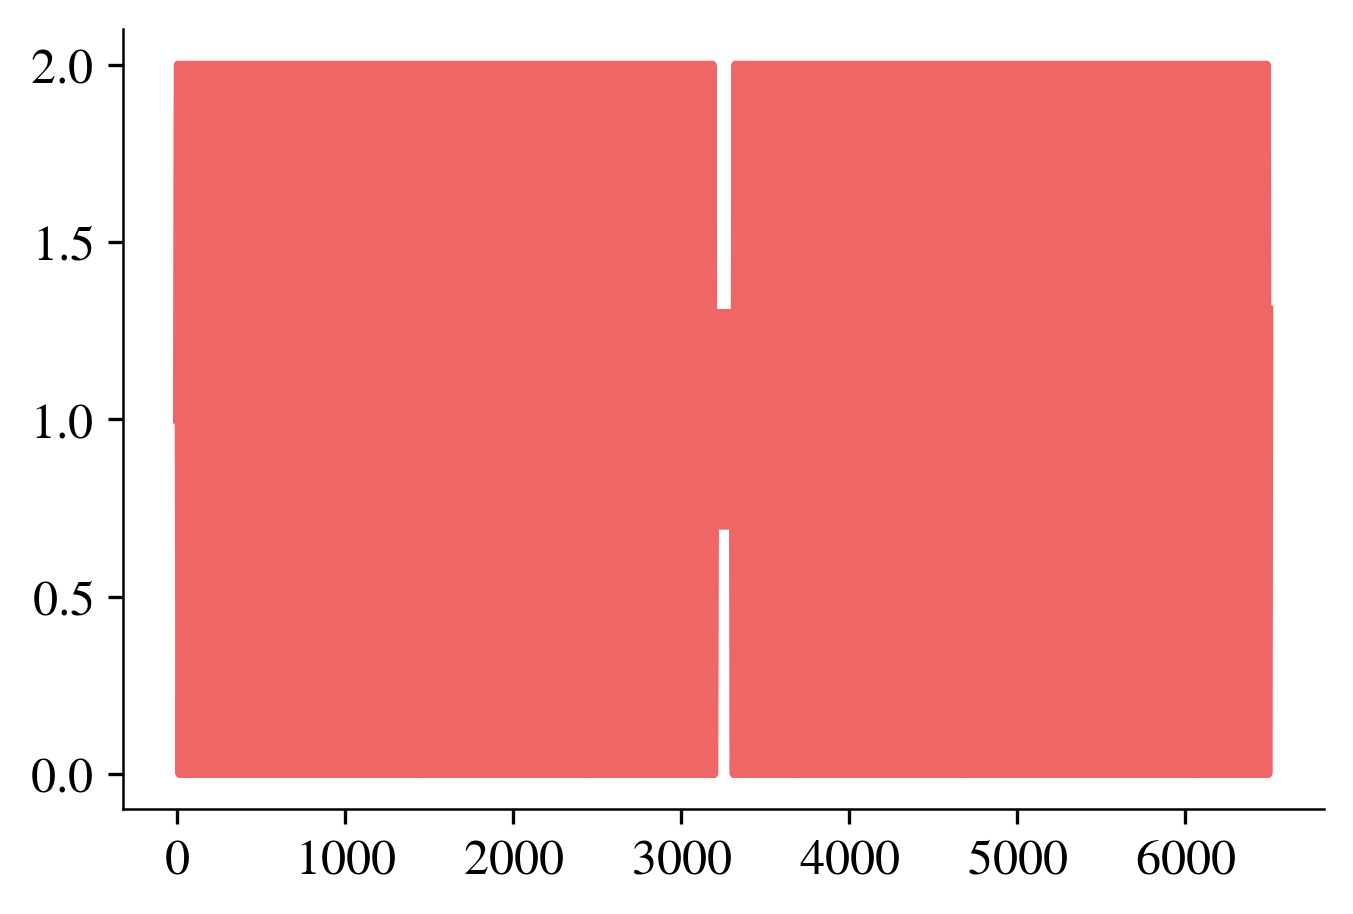

In [7]:
fig, ax = plt.subplots(figsize=(s1, s2))
input_scale=8*2
I_CC = np.zeros(600*input_scale)
# sampling rate
sr = 100.0
# sampling interval
ts = 1.0/sr
t = np.arange(0,2*input_scale,ts)

freqx=5
freq = freqx   
y = np.sin(2*np.pi*freq*t)+1

# print(y)
I_CC[0:int(2*input_scale*sr)] = y 


# sampling rate
shift= 20
sr_2 = 100.0+shift
ts_2 = 1.0/sr_2
t2 = np.arange(0,1,ts_2)
freq = freqx
y = 0.3*np.sin(2*(np.pi)*freq*t2)+1


I_CC[int(2*input_scale*sr):int((2*input_scale+1)*sr+shift)] = y 

freq = freqx  
y = np.sin(2*(np.pi)*freq*t)+1

I_CC[int((2*input_scale+1)*sr+shift-12):int((4*input_scale+1)*sr+shift-12)] = 2-y



plt.plot(np.arange(0,4*input_scale+1,ts)*int(sr),I_CC[0:int((4*input_scale+1)*sr)])


In [8]:
pixel_ed =int((4*input_scale+1)*sr+shift-12)

In [9]:
mark_pos= int(2*input_scale*sr)

(1.0, 5.508)

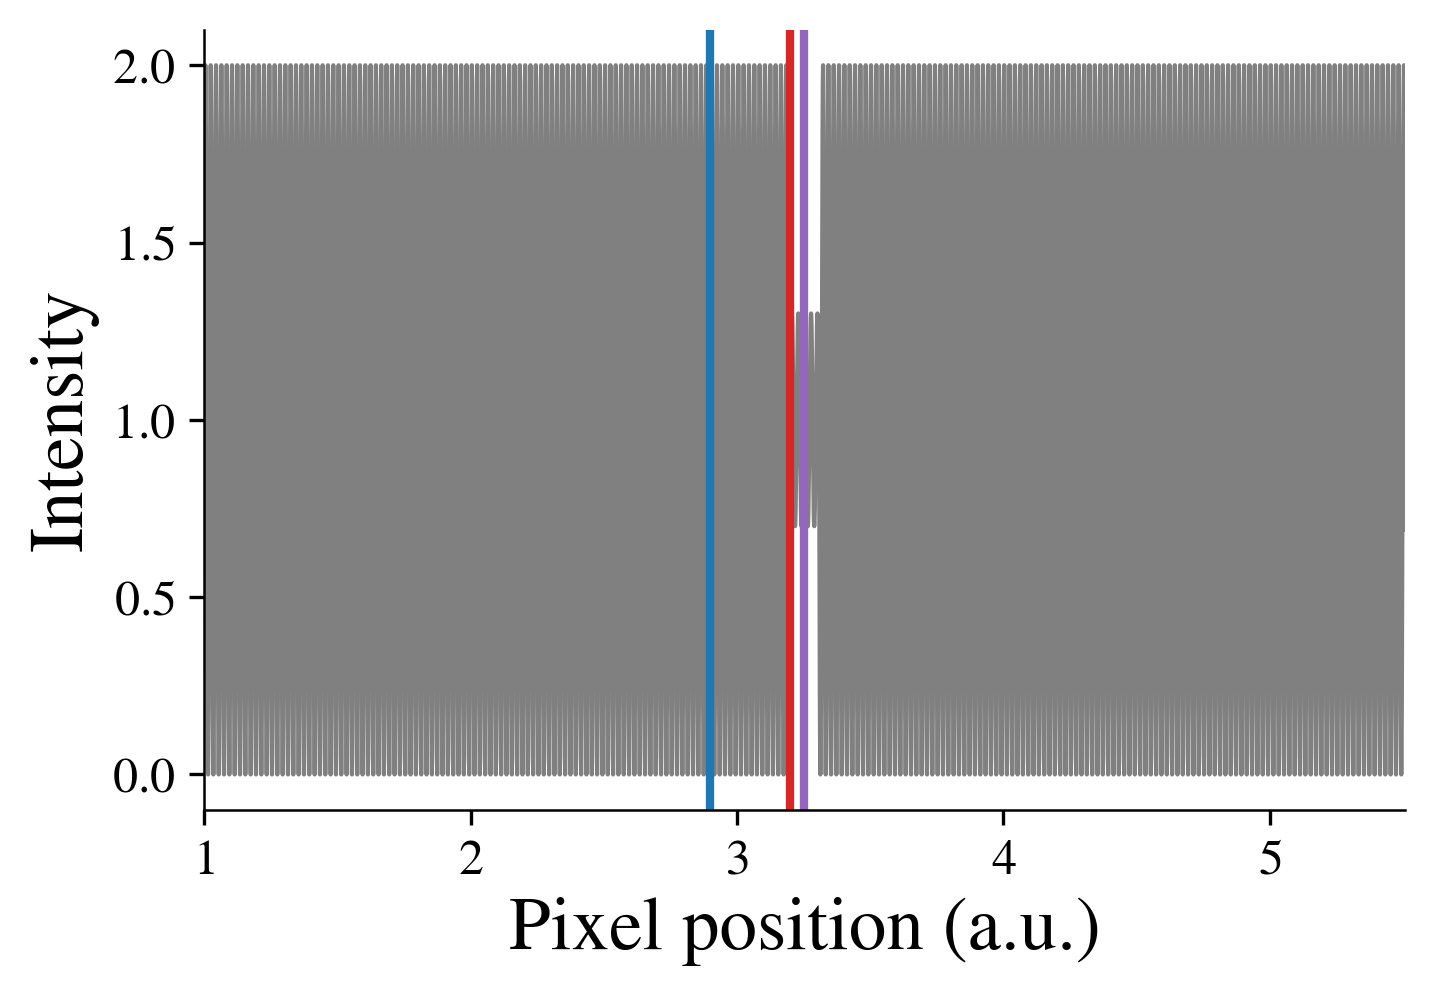

In [10]:
plt.figure(figsize=(s1, s2))
plt.plot((np.arange(0,(4*input_scale+1)/1000,ts/1000)*int(sr)),I_CC[0:int((4*input_scale+1)*sr)],linewidth=1
        ,color='grey')
plt.axvline(x=(mark_pos-300)/1000,color='tab:blue')
plt.axvline(x=(mark_pos+50)/1000,color='tab:purple')
plt.axvline(x=(mark_pos+0)/1000,color='tab:red')
plt.xlabel('Pixel position (a.u.)')
plt.ylabel('Intensity')
plt.xlim([1000/1000,(pixel_ed -1000)/1000])

In [11]:
def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

In [12]:
X = normalize(
    I_CC[0:int((4*input_scale+1)*sr+shift-12)],
    {'actual': {'lower': 0, 'upper': 2}, 'desired': {'lower': 0, 'upper': 255}}
) 

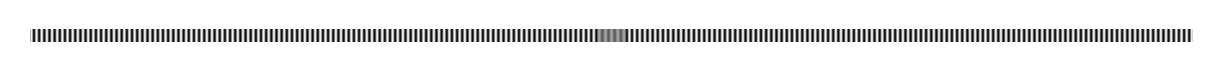

In [13]:
X_2D = np.zeros((50,int((4*input_scale+1)*sr+shift-12)))

for i in range(50):
    X_2D[i,:] = np.array(X) 

plt.figure(figsize=(5, 3))
plt.axis('off')
plt.imshow(X_2D[:,1000:pixel_ed-1000],cmap='gray')

In [14]:
from tqdm import tqdm

-5.329070518200751e-15


(0.0, 1800.0)

<Figure size 1550.01x1033.34 with 0 Axes>

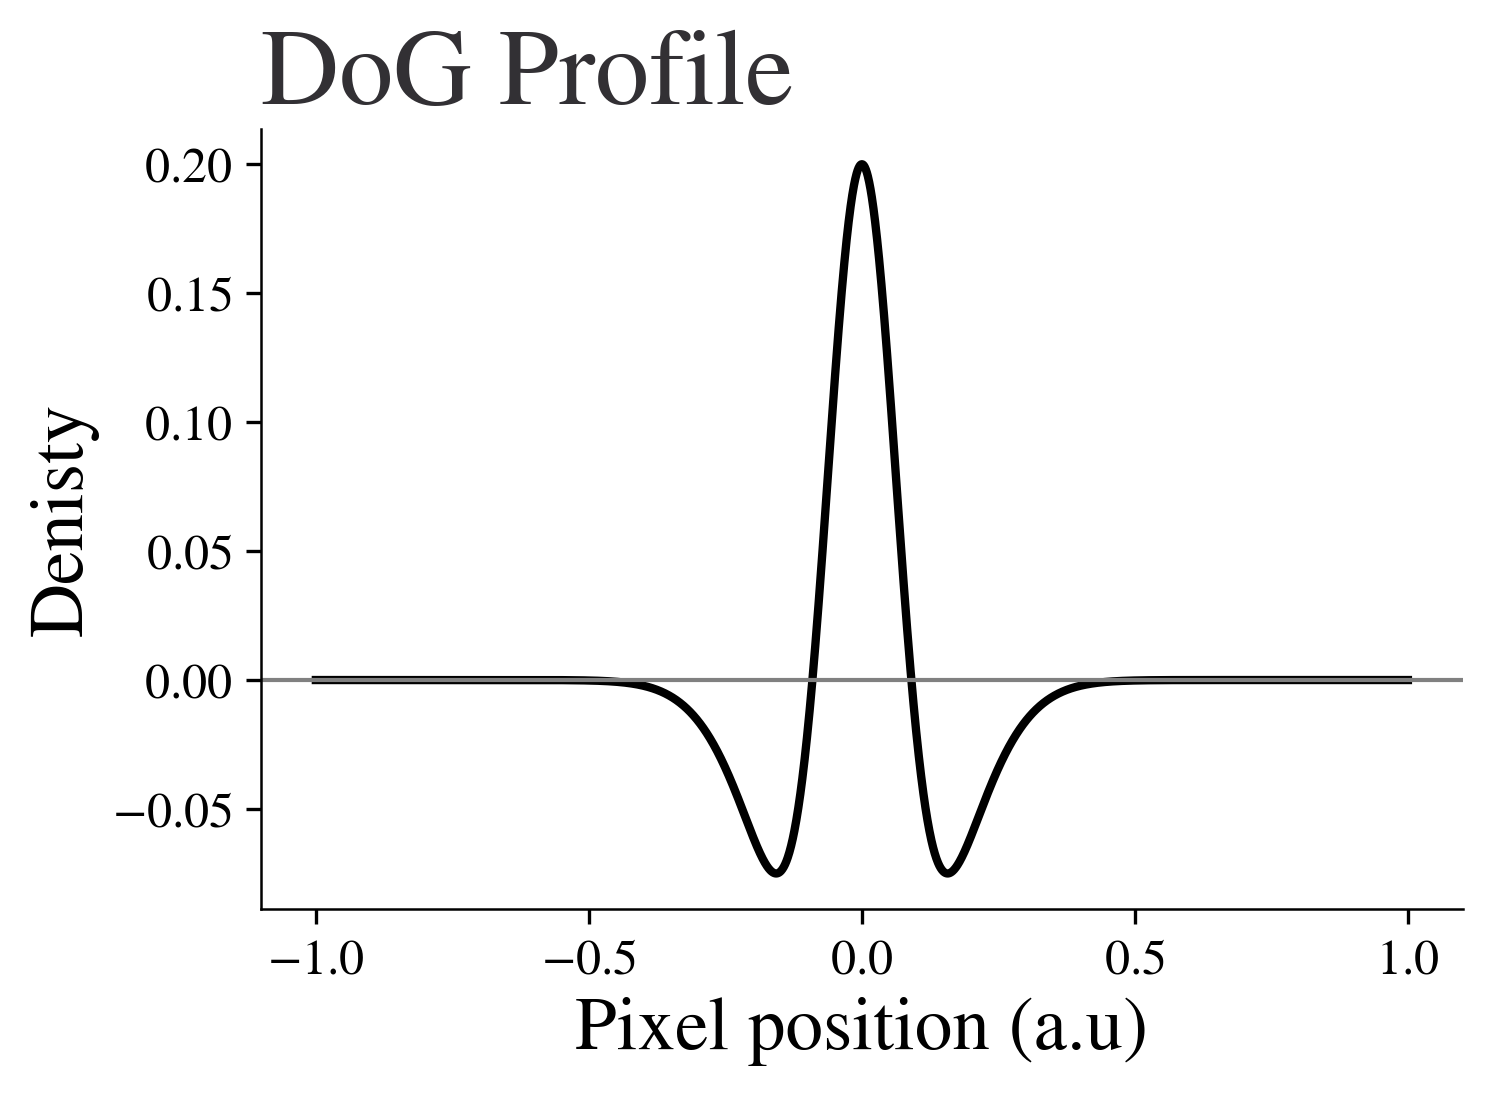

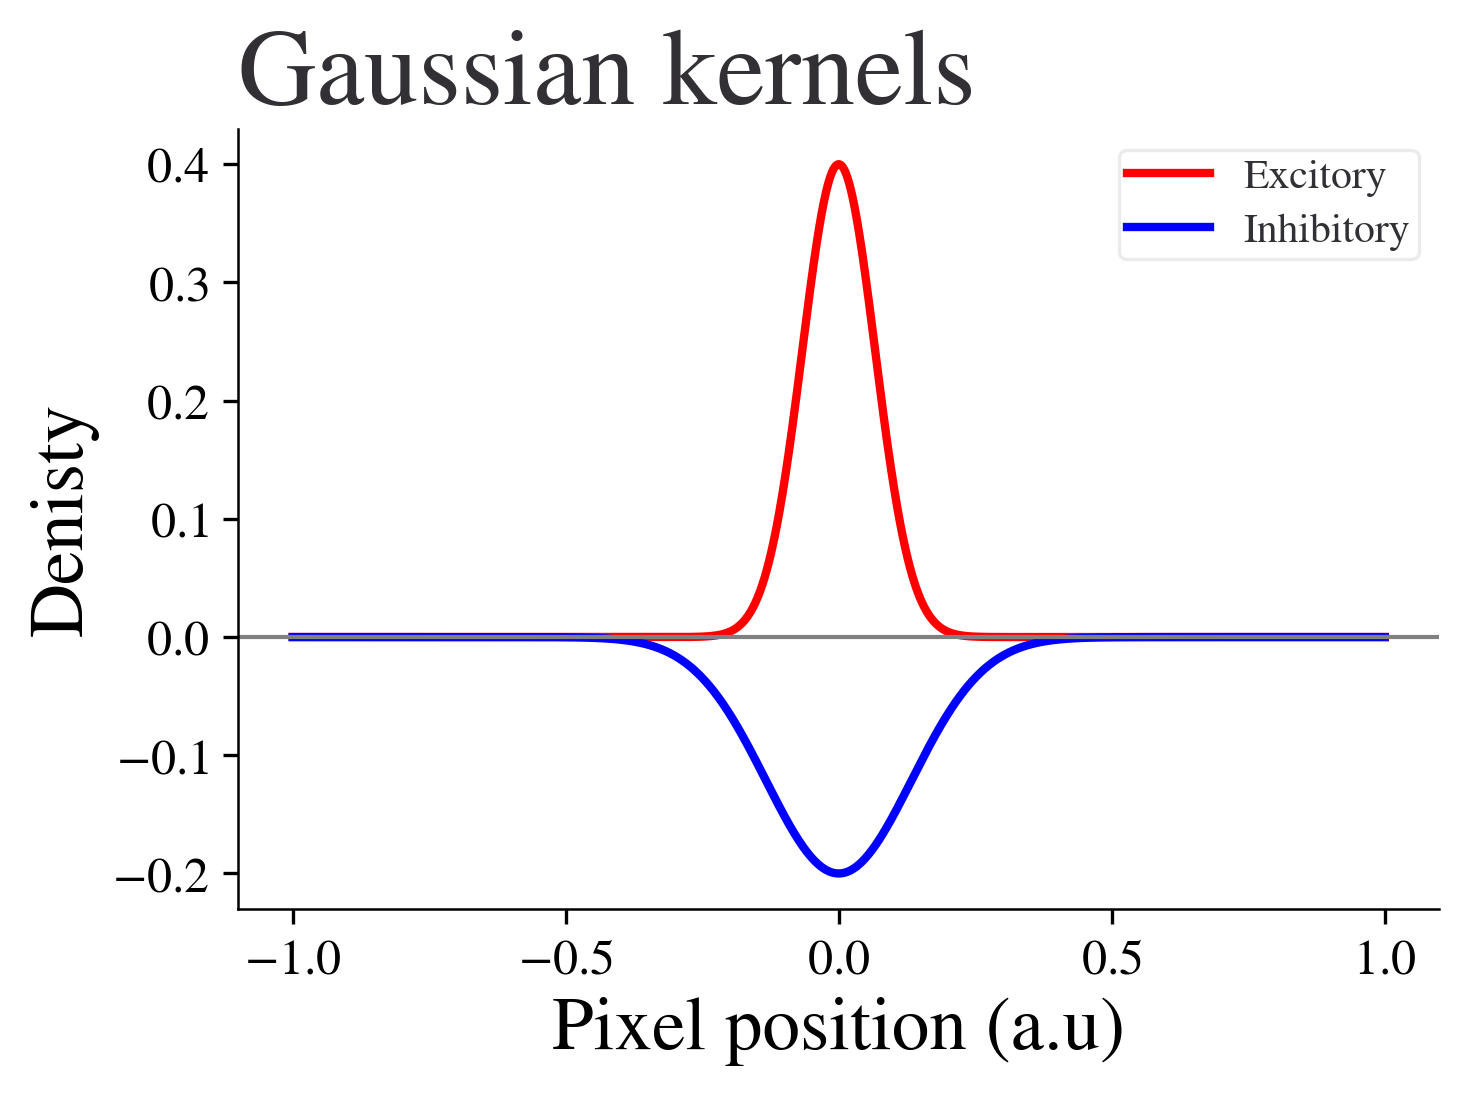

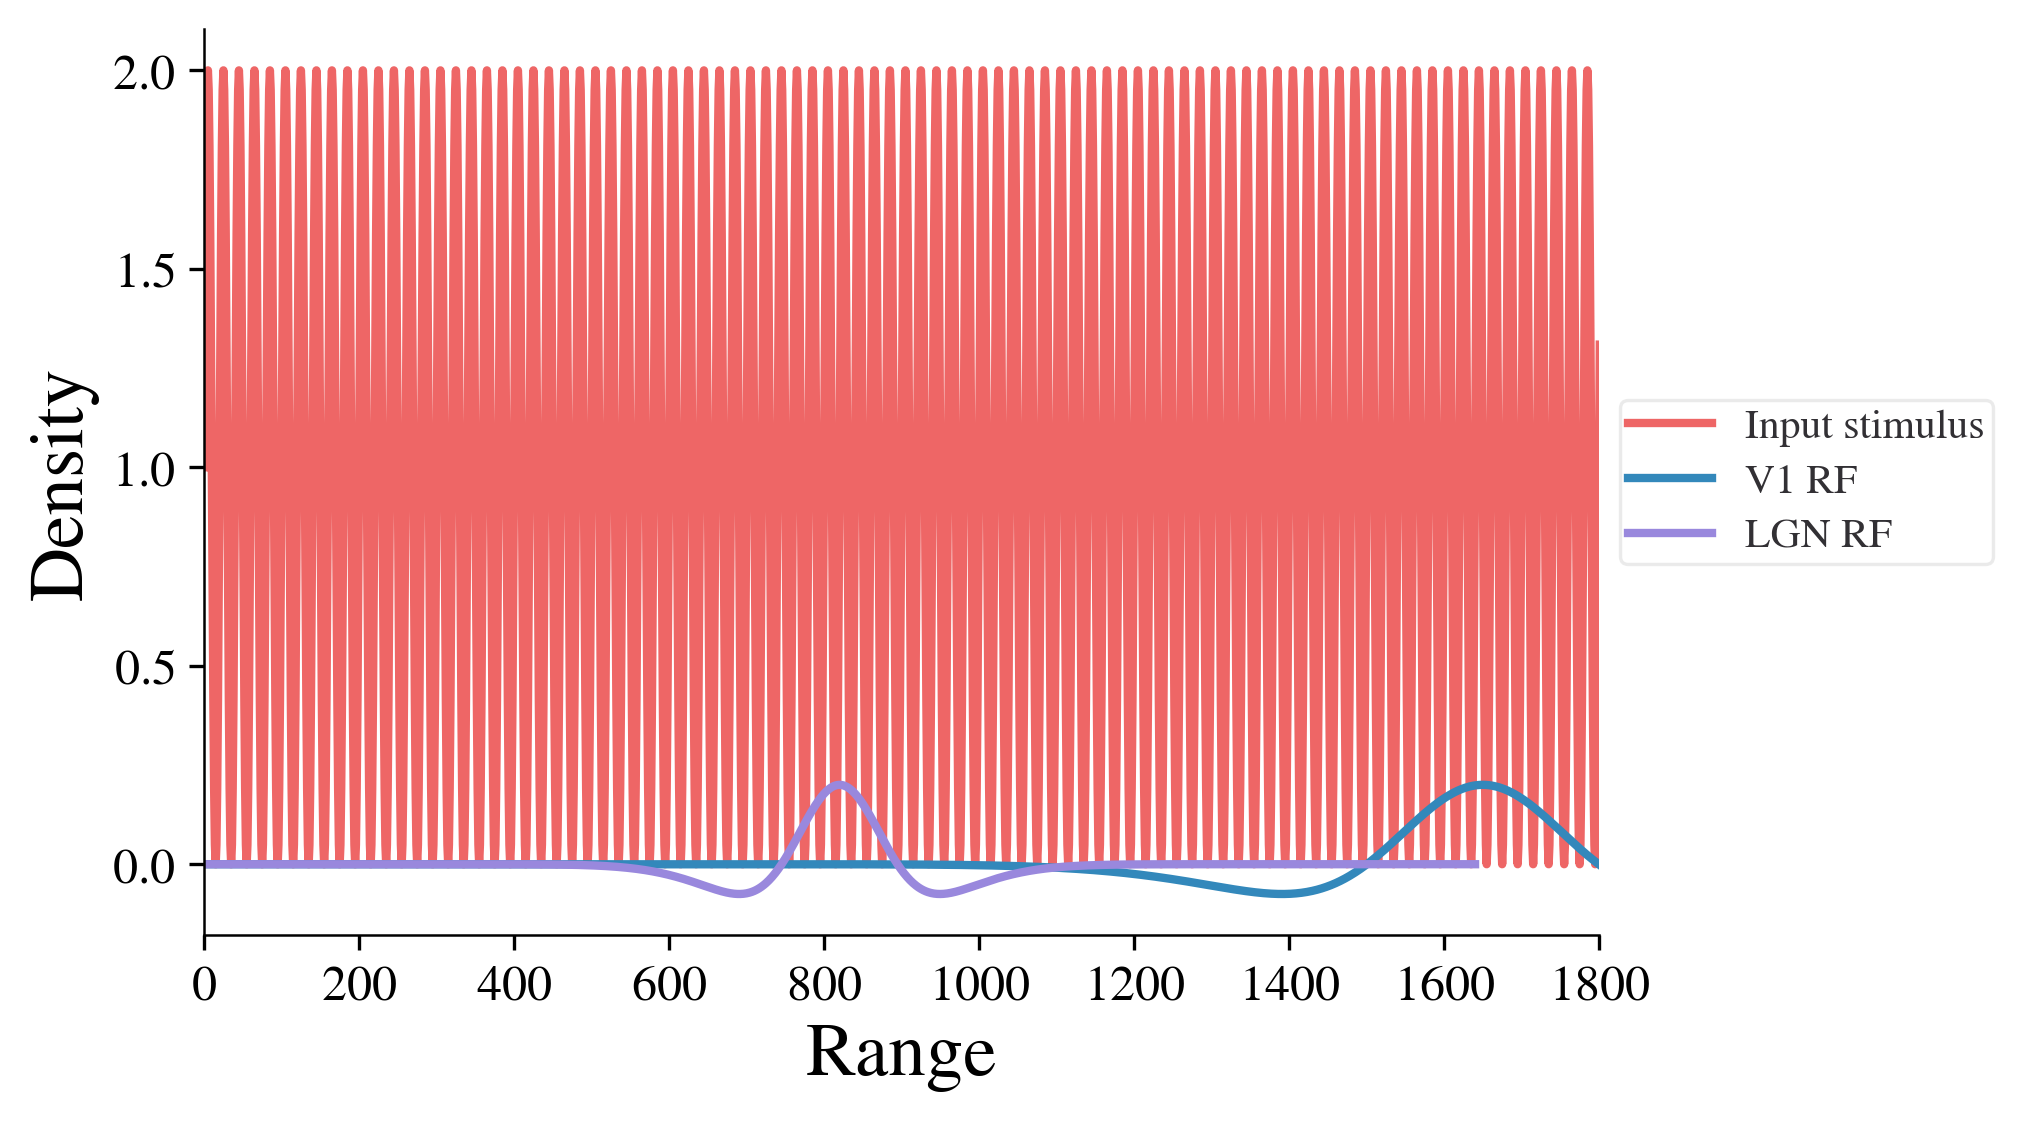

In [15]:
A = 1
B = 115
C = 20
this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23

t_scale = 0.75
dt = 0.1 

####
unit_2_scale=1
LGN_RF_scale =55
V1_RF_scale = LGN_RF_scale*2
dp=0.1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale*1.5),dp*10*int(LGN_RF_scale*1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale*1.5)*unit_2_scale,dp*10*int(V1_RF_scale*1.5)*unit_2_scale+dp,dp) 



timestep = int(np.round(400 * t_scale ))

T = timestep * dt


boundary_size = 10 
pixel_size = int((4*input_scale+1)*sr+shift-12) #+2*boundary_size

I_CC_norm = normalize(
    I_CC[0:pixel_size],
    {'actual': {'lower': 0, 'upper': 2}, 'desired': {'lower': 0, 'upper': 1}}
) 

I = np.zeros((timestep, pixel_size+2*boundary_size))
I[10:200,boundary_size:-boundary_size] = I_CC_norm


fig = plt.figure(figsize=(s1, s2))

v1_sigma_Ex_scale = 1
v1_sigma_inh_scale =1
v1_amp_scale = 1
# fixed basline scale *3
this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
this_v1_sigma_inh = 0.2*v1_sigma_inh_scale



X_vec = np.zeros((timestep,pixel_size+2*boundary_size  ))
X_vec_V1 = np.zeros((timestep,pixel_size+2*boundary_size  ))
t=0
_,norm_G_Ex,norm_G_Inh= net.fun_feedforward(X_vec_V1[t,:],A,B,C,I[t,:],
                                            filter_unit_2,this_v1_sigma_Ex ,
                                            this_v1_sigma_inh,  
                                            amp_inh=this_amp_inh,
                                            RF_scale=V1_RF_scale, amp_exc=this_amp_exc)


plt.figure(figsize=(s1, s2))
plt.plot(np.linspace(-1,1,len(norm_G_Ex)),B*norm_G_Ex-C*norm_G_Inh,c='black')
plt.xlabel("Pixel position (a.u)")
plt.ylabel("Denisty")
plt.axhline(y=0,c='grey',linewidth=1)
plt.title('DoG Profile')

plt.figure(figsize=(s1, s2))
plt.plot(np.linspace(-1,1,len(norm_G_Ex)),B*norm_G_Ex,c='r',label='Excitory')
plt.plot(np.linspace(-1,1,len(norm_G_Ex)),-C*norm_G_Inh,c='b',label='Inhibitory')
plt.xlabel("Pixel position (a.u)")
plt.ylabel("Denisty")
plt.axhline(y=0,c='grey',linewidth=1)
plt.legend()
plt.title('Gaussian kernels')



plt.figure()

plt.plot(np.arange(0,4*input_scale+1,ts)*int(sr),I_CC[0:int((4*input_scale+1)*sr)],label='Input stimulus')
plt.plot(B*norm_G_Ex-C*norm_G_Inh, label='V1 RF')
base_kernel = B*norm_G_Ex-C*norm_G_Inh

print(np.sum(base_kernel))



_,norm_G_Ex,norm_G_Inh= net.fun_feedforward(X_vec[t,:],A,B,C,I[t,:],
                                            filter_unit,dt,dt*2,
                                            amp_inh=this_amp_inh,
                                            RF_scale=LGN_RF_scale,
                                            amp_exc=this_amp_exc
                                           )
plt.plot(B*norm_G_Ex-C*norm_G_Inh, label='LGN RF')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))#, bbox_to_anchor=(1, 0.5))
plt.xlabel("Range")
plt.ylabel("Density")

plt.xlim([0, 1800])

In [16]:
this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23


this_amp_list = np.array([0.75,1,1.25,1.5,1.75,2])#,
v1_exc_amp_response_list = []
this_alpha= 0.003*a_scale

for v1_amp_scale in tqdm(this_amp_list):

    v1_sigma_Ex_scale = 1 # *unit_2_scale
    v1_sigma_inh_scale =1  # *unit_2_scale

    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
    this_v1_amp_inh = this_amp_inh
    this_v1_amp_exc = this_amp_exc*v1_amp_scale

    X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , 
                                                                            v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_v1_amp_exc  )


    this_X_vec =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
    this_X_vec_V1 =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
    this_X_vec_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
    this_X_vec_V1_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
    
    v1_exc_amp_response_list.append (this_X_vec_V1_2nd)
    



# Figure 6J

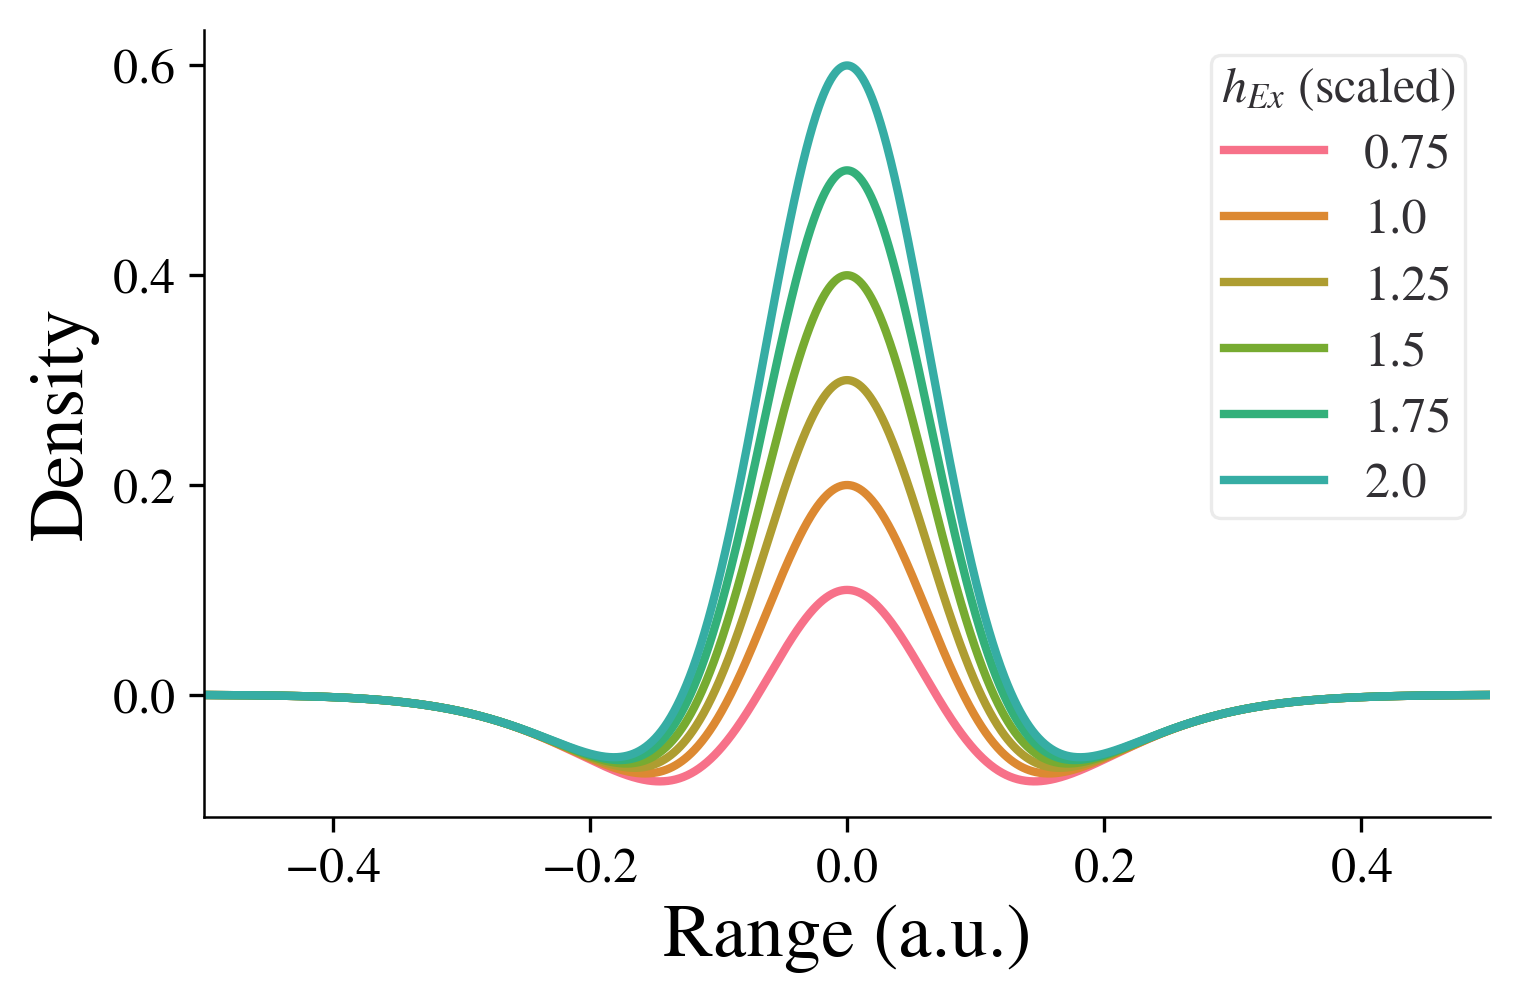

In [17]:
pal=sns.color_palette("husl", 10)


a = pal.as_hex()
colors = cycler('color', a)

plt.rc('axes', facecolor='white', edgecolor='black',
       axisbelow=True, grid=True, prop_cycle= colors)

unit_2_scale = 1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale*1.5),dp*10*int(LGN_RF_scale*1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale*1.5)*unit_2_scale,dp*10*int(V1_RF_scale*1.5)*unit_2_scale+dp,dp) 


this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23
this_alpha=0.003*a_scale
this_amp_list =np.array([0.75,1,1.25,1.5,1.75,2])
X_vec = np.zeros((timestep,pixel_size+2*boundary_size  ))
X_vec_V1 = np.zeros((timestep,pixel_size+2*boundary_size  ))


plt.figure(figsize=(s1, s2))
for v1_amp_scale in tqdm(this_amp_list):

    v1_sigma_Ex_scale = 1 # *unit_2_scale
    v1_sigma_inh_scale =1 # *unit_2_scale

    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
    this_v1_amp_inh = this_amp_inh
    this_v1_amp_exc = this_amp_exc*v1_amp_scale
    
    

    t=0
    _,norm_G_Ex,norm_G_Inh= net.fun_feedforward(X_vec_V1[t,:],A,B,C,I[t,:],filter_unit_2,this_v1_sigma_Ex ,this_v1_sigma_inh,amp_inh=this_v1_amp_inh,RF_scale=V1_RF_scale, amp_exc=this_v1_amp_exc)



    plt.plot(np.linspace(-1,1,len(norm_G_Ex)),B*norm_G_Ex-C*norm_G_Inh,label=str(v1_amp_scale))

plt.xlabel("Range (a.u.)")
plt.ylabel("Density")

plt.legend(title=r'$h_{Ex}$ (scaled)',loc='upper right', fontsize=12)  



plt.xlim([-0.5,0.5])
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_exc_amp_kernel.'+'png'), dpi=300)
with open(os.path.join(fig_save_path , 'cc_exc_amp_kernel.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)


# Figure 6G, 6F

0 : 67.0018077080469
16.35832156057596
1 : 131.4066196824461
33.446120411221344
2 : 221.75251410476938
56.303960796099254
3 : 337.2414181474466
84.65716051225631
4 : 479.58886190775064
118.21322988034044
5 : 649.2662060566204
156.66643583880668


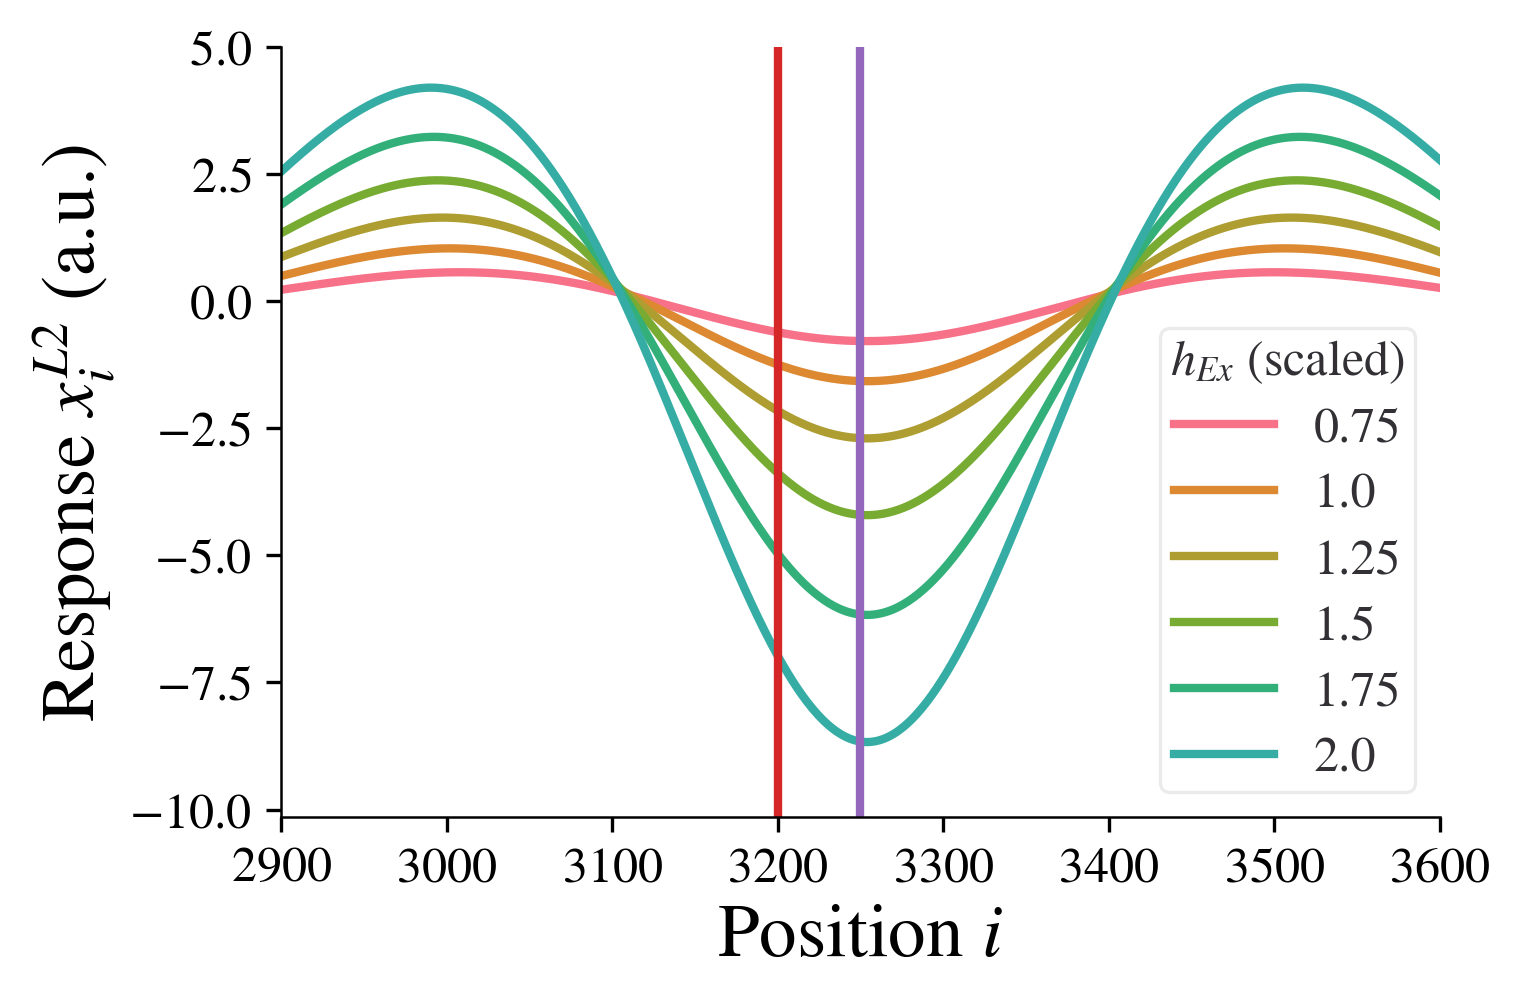

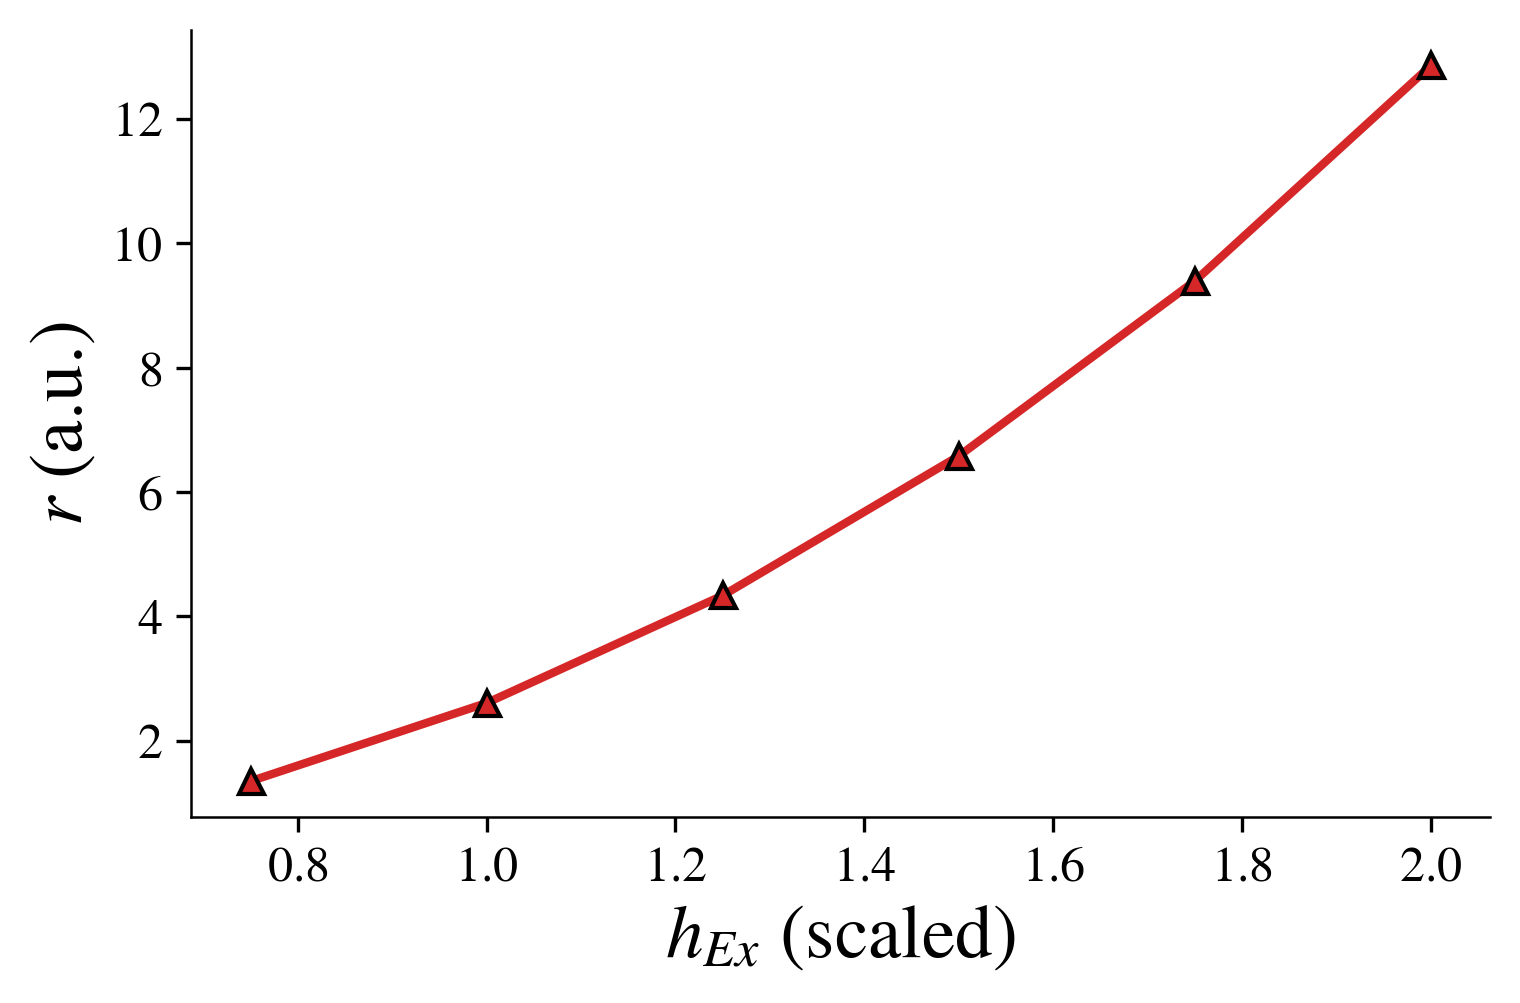

In [18]:

plt.figure(figsize=(s1, s2))
this_amp_list = np.array([0.75,1,1.25,1.5,1.75,2])

r_list= []
for i in range(len(this_amp_list)):
    plt.plot(np.arange(0,pixel_size,1), v1_exc_amp_response_list[i][180,boundary_size:-boundary_size], label=str(this_amp_list[i]))
    this_response =  v1_exc_amp_response_list[i][180,boundary_size:-boundary_size]
    
    mark_pos= int(2*input_scale*sr)
    win_left = this_response[mark_pos-300:mark_pos]
    win_left_st = np.argmax(win_left)
    win_left_ed = np.argmin(win_left) 
    
    if win_left_st<win_left_ed:
        r_surround= np.sum(np.abs(win_left[win_left_st:win_left_ed]))
    else:
        r_surround= np.sum(np.abs(win_left[win_left_ed:win_left_st]))
    
    
    win_right = this_response[mark_pos:mark_pos+50]
    
    win_right_st = np.argmax(win_right)
    win_right_ed = np.argmin(win_right) 
    
    if win_right_st>win_right_ed:
        r_center= np.sum(np.abs(win_left[win_right_ed:win_right_st]))
    else:
        r_center= np.sum(np.abs(win_left[win_right_st:win_right_ed]))
    

    print(i,":",r_surround)
    print(r_center)
    r_list.append(np.max(win_left)-np.min(win_right))

plt.xlabel('Position $i$')

plt.ylabel('Response $x^{L2}_{i}$ (a.u.)')

plt.axvline(x=mark_pos+50,color='tab:purple')
plt.axvline(x=mark_pos+0,color='tab:red')

plt.legend(title=r'$h_{Ex}$ (scaled)',loc='lower right',fontsize=12, title_fontsize=12 )#bbox_to_anchor=(1, 0.5))



plt.xlim(mark_pos-300,mark_pos+400 )
plt.ylim([-10.15, 5])
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_exc_amp_response.'+'png'), dpi= 300)
with open(os.path.join(fig_save_path , 'cc_exc_amp_response.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)


plt.figure(figsize=(s1, s2))

plt.plot(this_amp_list,r_list,marker='^',c='tab:red')
plt.xlabel(r'$h_{Ex}$ (scaled)')
plt.ylabel('$r$ (a.u.)')

plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_exc_amp_rep.'+'png'), dpi=300)
with open(os.path.join(fig_save_path , 'cc_exc_amp_rep.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)




# Figure 5E right panel

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


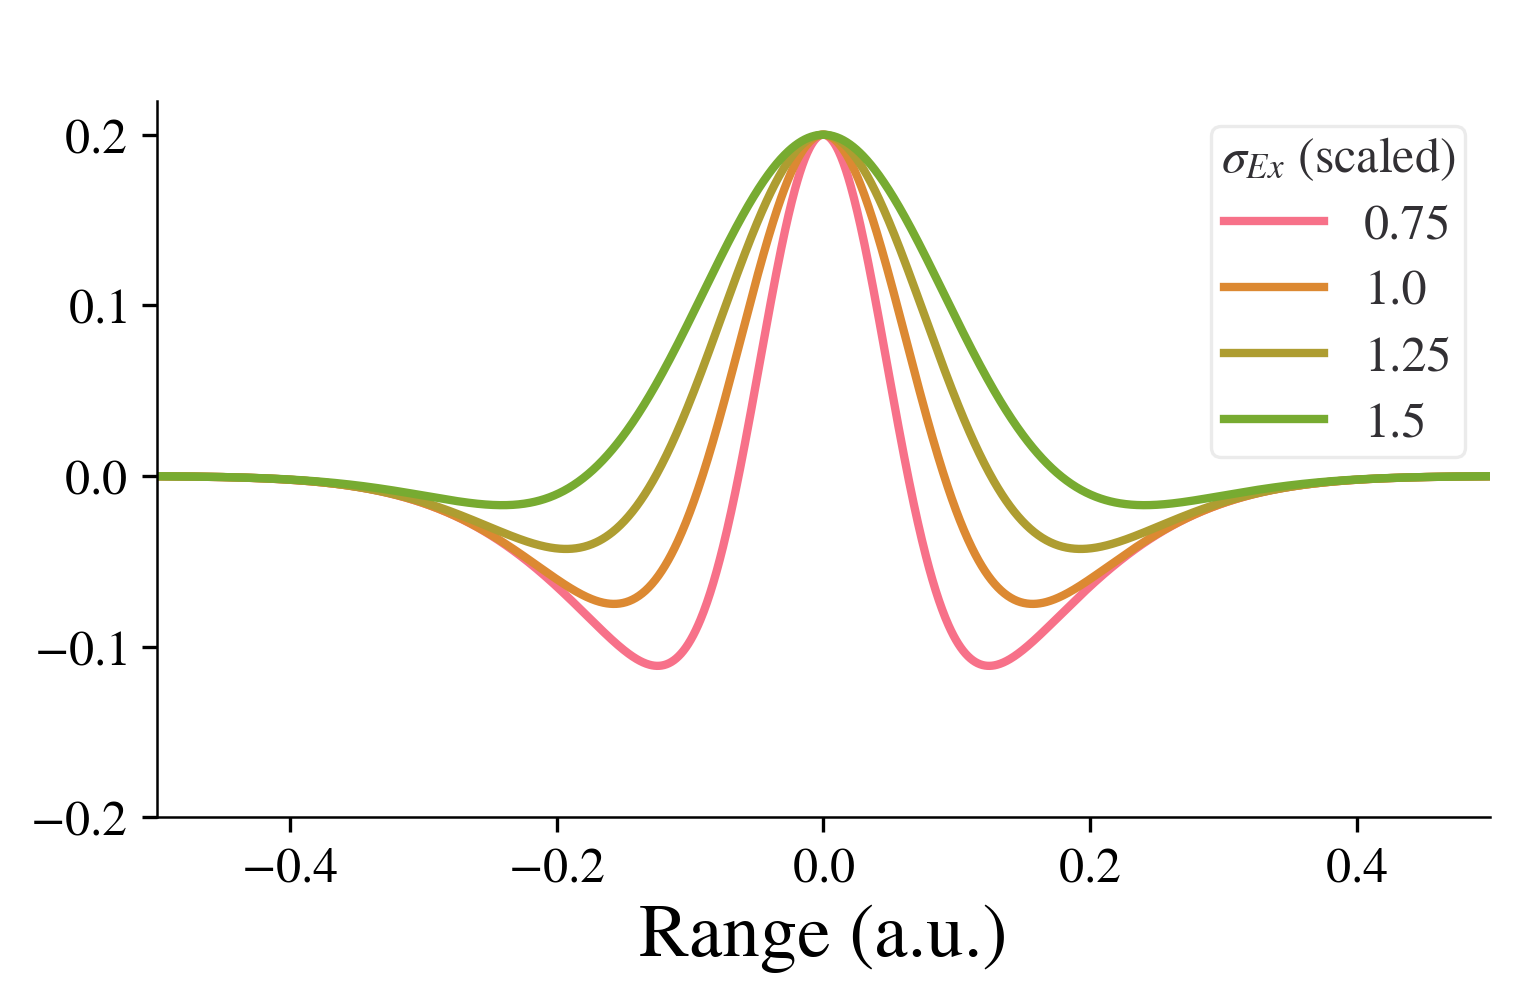

In [19]:
this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23


pal=sns.color_palette("husl", 10)


a = pal.as_hex()
colors = cycler('color', a)

plt.rc('axes', facecolor='white', edgecolor='black',
       axisbelow=True, grid=True, prop_cycle= colors)


unit_2_scale = 1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale*1.5),dp*10*int(LGN_RF_scale*1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale*1.5)*unit_2_scale,dp*10*int(V1_RF_scale*1.5)*unit_2_scale+dp,dp) 


this_alpha=0.003*a_scale
this_sig_list =np.array([0.75,1,1.25,1.5])*1 #,1.75,2])*1
X_vec = np.zeros((timestep,pixel_size+2*boundary_size  ))
X_vec_V1 = np.zeros((timestep,pixel_size+2*boundary_size  ))


plt.figure(figsize=(s1, s2))

for v1_exc_sigma_scale in tqdm(this_sig_list):

    v1_sigma_Ex_scale = 1 * v1_exc_sigma_scale# *unit_2_scale
    v1_sigma_inh_scale =1 # *unit_2_scale
    v1_amp_scale = 1
    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale    
    

    t=0
    _,norm_G_Ex,norm_G_Inh= net.fun_feedforward(X_vec_V1[t,:],A,B,C,I[t,:],filter_unit_2,this_v1_sigma_Ex ,this_v1_sigma_inh,amp_inh=this_amp_inh,RF_scale=V1_RF_scale, amp_exc=this_amp_exc)



    plt.plot(np.linspace(-1,1,len(norm_G_Ex)),B*norm_G_Ex-C*norm_G_Inh,label=str(v1_exc_sigma_scale))

plt.xlabel("Range (a.u.)")

    

plt.legend(title='$\sigma_{Ex}$ (scaled)',loc='upper right',fontsize=12, title_fontsize=12)#,  bbox_to_anchor=(1, 0.5))
plt.xlim([-0.5,0.5])

plt.ylim([-0.2,0.22])
plt.title('\t', loc='center',fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_exc_sig_kernel.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'cc_exc_sig_kernel.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)



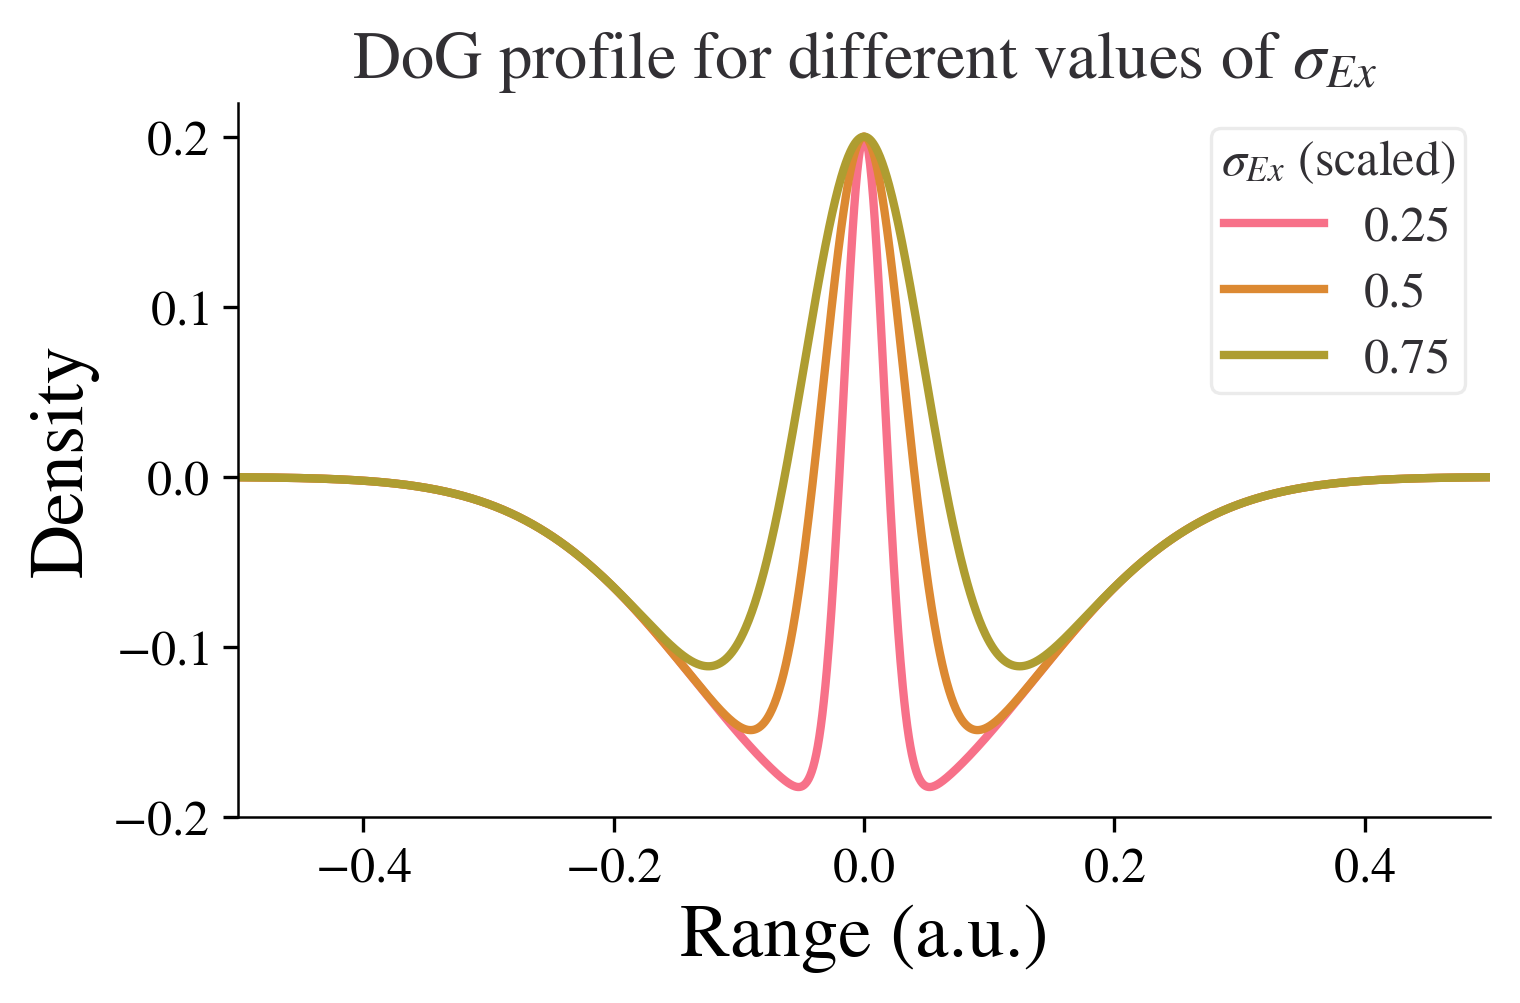

In [20]:
this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23


pal=sns.color_palette("husl", 10)


a = pal.as_hex()
colors = cycler('color', a)

plt.rc('axes', facecolor='white', edgecolor='black',
       axisbelow=True, grid=True, prop_cycle= colors)


unit_2_scale = 1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale*1.5),dp*10*int(LGN_RF_scale*1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale*1.5)*unit_2_scale,dp*10*int(V1_RF_scale*1.5)*unit_2_scale+dp,dp) 


this_alpha=0.003*a_scale
this_sig_list =np.array([0.25,0.5,0.75])*1 #,1.75,2])*1
X_vec = np.zeros((timestep,pixel_size+2*boundary_size  ))
X_vec_V1 = np.zeros((timestep,pixel_size+2*boundary_size  ))


plt.figure(figsize=(s1, s2))

for v1_exc_sigma_scale in tqdm(this_sig_list):

    v1_sigma_Ex_scale = 1 * v1_exc_sigma_scale# *unit_2_scale
    v1_sigma_inh_scale =1 # *unit_2_scale
    v1_amp_scale = 1
    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale    
    

    t=0
    _,norm_G_Ex,norm_G_Inh= net.fun_feedforward(X_vec_V1[t,:],A,B,C,I[t,:],filter_unit_2,this_v1_sigma_Ex ,this_v1_sigma_inh,amp_inh=this_amp_inh,RF_scale=V1_RF_scale, amp_exc=this_amp_exc)



    plt.plot(np.linspace(-1,1,len(norm_G_Ex)),B*norm_G_Ex-C*norm_G_Inh,label=str(v1_exc_sigma_scale))

plt.xlabel("Range (a.u.)")
plt.ylabel("Density")
    

plt.legend(title='$\sigma_{Ex}$ (scaled)',loc='upper right',fontsize=12, title_fontsize=12)#,  bbox_to_anchor=(1, 0.5))
plt.xlim([-0.5,0.5])

plt.ylim([-0.2,0.22])
plt.title(r'DoG profile for different values of $\sigma_{Ex}$', loc='center',fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_sm_exc_sig_kernel.'+'png'), dpi=300)
with open(os.path.join(fig_save_path , 'cc_sm_exc_sig_kernel.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)




In [21]:
this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23


this_exc_list = [0.25,0.5,0.75,1,1.25,1.5]#,1.75,2]#,
v1_exc_sigma_response_list = []
this_alpha=0.003*a_scale
v1_amp_scale=1
for v1_exc_scale in tqdm(this_exc_list):

    v1_sigma_Ex_scale = 1 * v1_exc_scale # *unit_2_scale
    v1_sigma_inh_scale =1  # *unit_2_scale
    v1_amp_scale = 1
    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
    this_v1_amp_inh = this_amp_inh*v1_amp_scale


    X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_amp_exc  )


    this_X_vec =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
    this_X_vec_V1 =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
    this_X_vec_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
    this_X_vec_V1_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
    
    v1_exc_sigma_response_list.append (this_X_vec_V1_2nd)
    




In [22]:
np.shape(v1_exc_sigma_response_list)

(6, 300, 6528)

# Figure 5B, 5A right panel

2 : 142.0878681804389
21.61863607647745
3 : 131.4066196824461
33.446120411221344
4 : 103.41807000876375
29.137971348403145
5 : 74.35713330427635
18.70903263306657


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


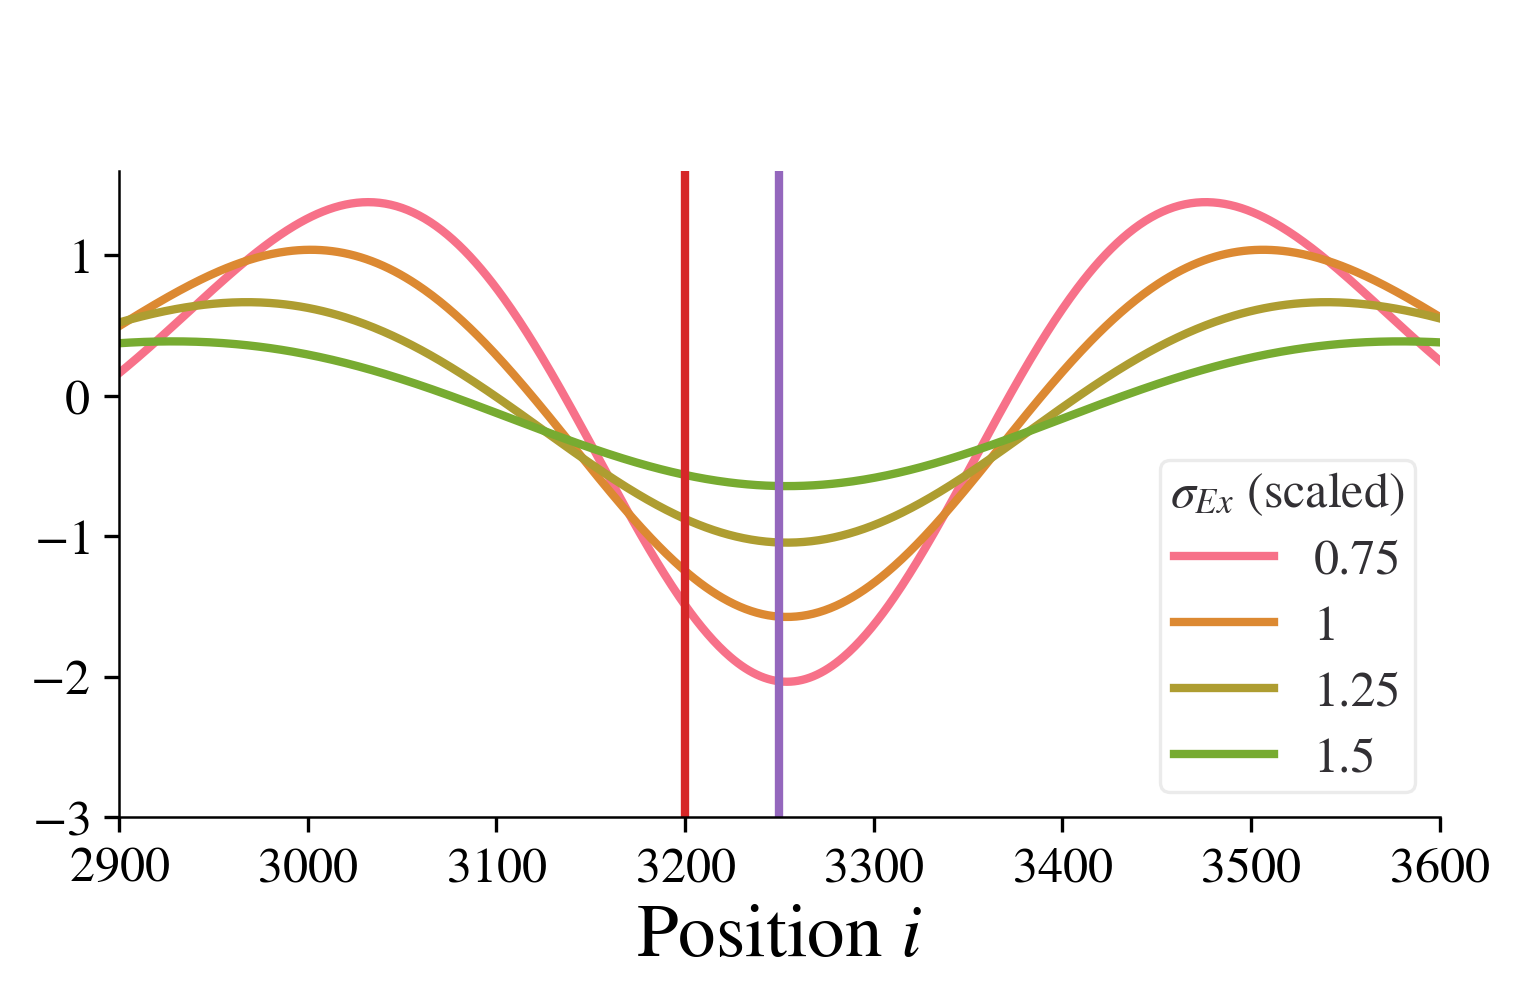

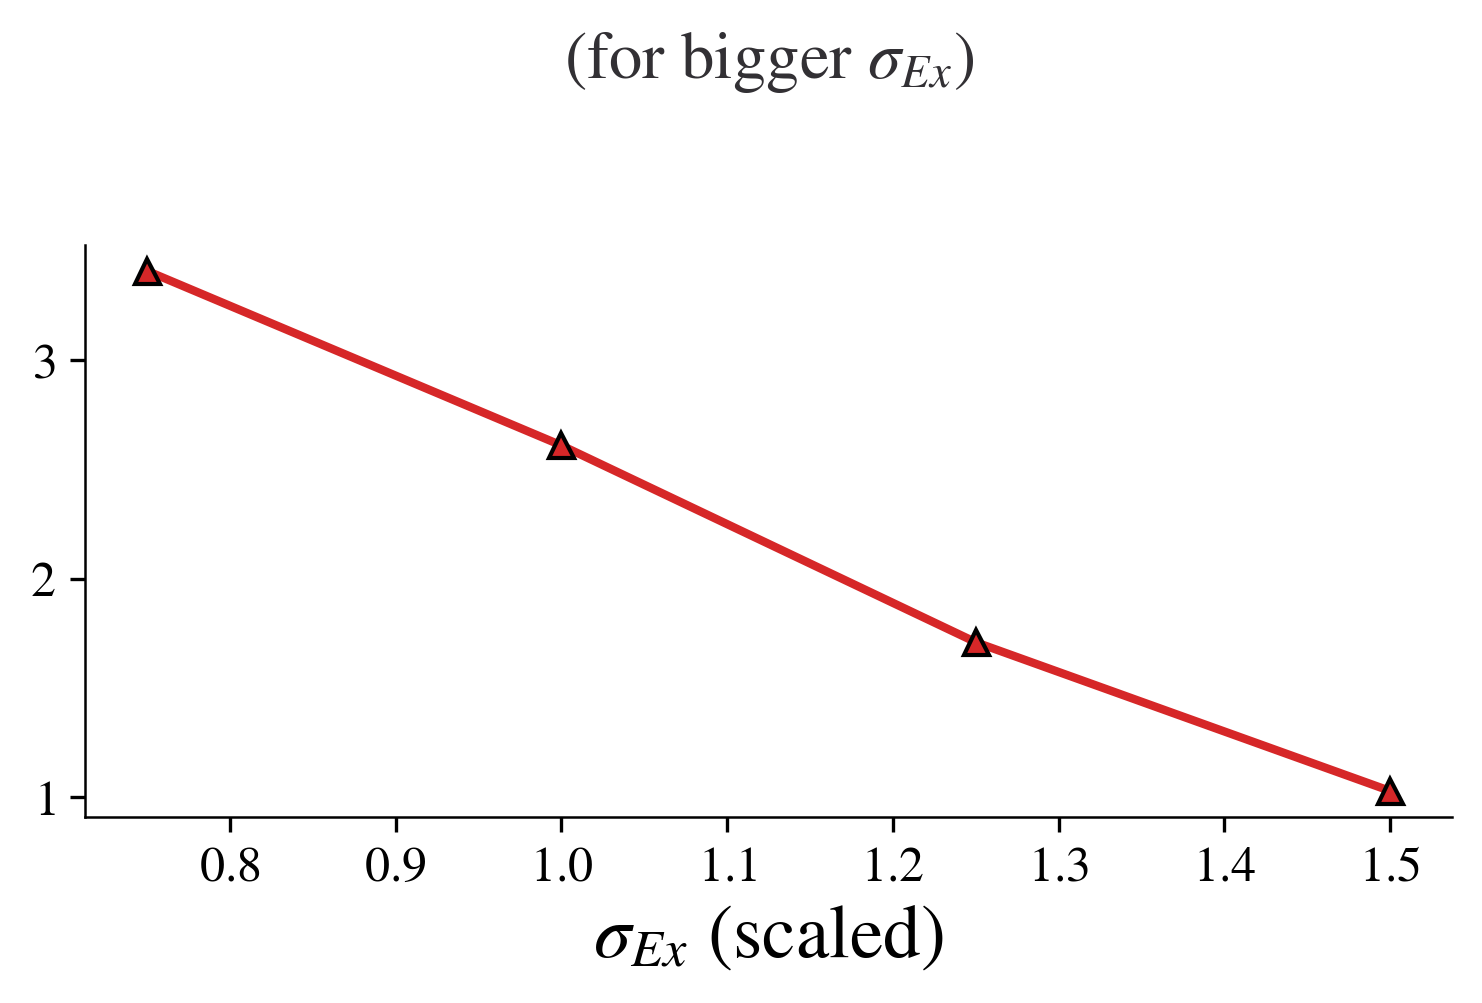

In [23]:

plt.figure(figsize=(s1, s2))

r_list= []
for i in range(2,len(this_exc_list)):
    plt.plot(np.arange(0,pixel_size,1),v1_exc_sigma_response_list[i][180,boundary_size:-boundary_size], 
             label=str(this_exc_list[i]))
    this_response = v1_exc_sigma_response_list[i][180,boundary_size:-boundary_size]

    mark_pos= int(2*input_scale*sr)
    win_left = this_response[mark_pos-300:mark_pos]
    win_left_st = np.argmax(win_left)
    win_left_ed = np.argmin(win_left) 
    
    if win_left_st<win_left_ed:
        r_surround= np.sum(np.abs(win_left[win_left_st:win_left_ed]))
    else:
        r_surround= np.sum(np.abs(win_left[win_left_ed:win_left_st]))
    
    
    win_right = this_response[mark_pos:mark_pos+50]
    
    win_right_st = np.argmax(win_right)
    win_right_ed = np.argmin(win_right) 
    
    if win_right_st>win_right_ed:
        r_center= np.sum(np.abs(win_left[win_right_ed:win_right_st]))
    else:
        r_center= np.sum(np.abs(win_left[win_right_st:win_right_ed]))
    print(i,":",r_surround)
    print(r_center)
    r_list.append(np.max(win_left)-np.min(win_right))

plt.xlabel('Position $i$')
plt.axvline(x=mark_pos+50,color='tab:purple')
plt.axvline(x=mark_pos+0,color='tab:red')

plt.title('\n\t', loc='center',fontsize=16)
plt.legend(title='$\sigma_{Ex}$ (scaled)',loc='lower right',fontsize=12, title_fontsize=12)#,  bbox_to_anchor=(1, 0.5))


plt.xlim(mark_pos-300,mark_pos+400 )

plt.ylim([-3, 1.6])

plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_exc_sig_response.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'cc_exc_sig_response.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)
    


plt.figure(figsize=(s1, s2))

plt.plot(this_exc_list[2:],r_list,marker='^',c='tab:red')
plt.xlabel(r'$\sigma_{Ex}$ (scaled)')#,fontsize=12)
plt.title(r'(for bigger $\sigma_{Ex}$)' + '\n\n', loc='center',fontsize=16)


plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_exc_sig_rep.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'cc_exc_sig_rep.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)
    






0 : 43.8231150637996
7.380755089102763
1 : 111.91684259149685
6.059134346603163
2 : 142.0878681804389
21.61863607647745


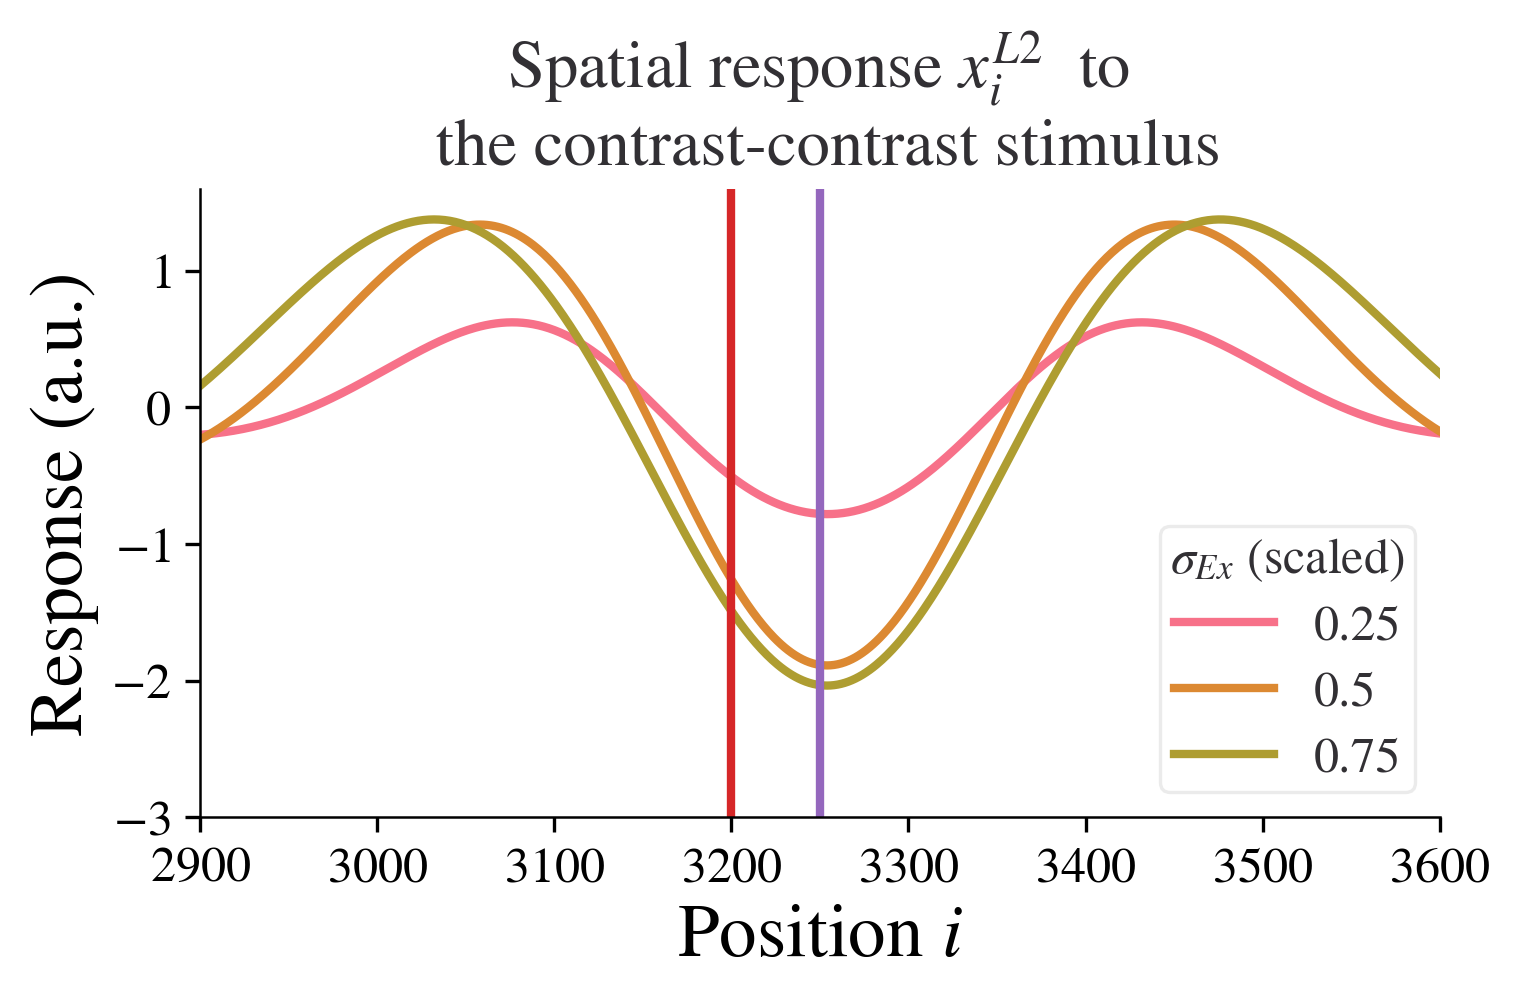

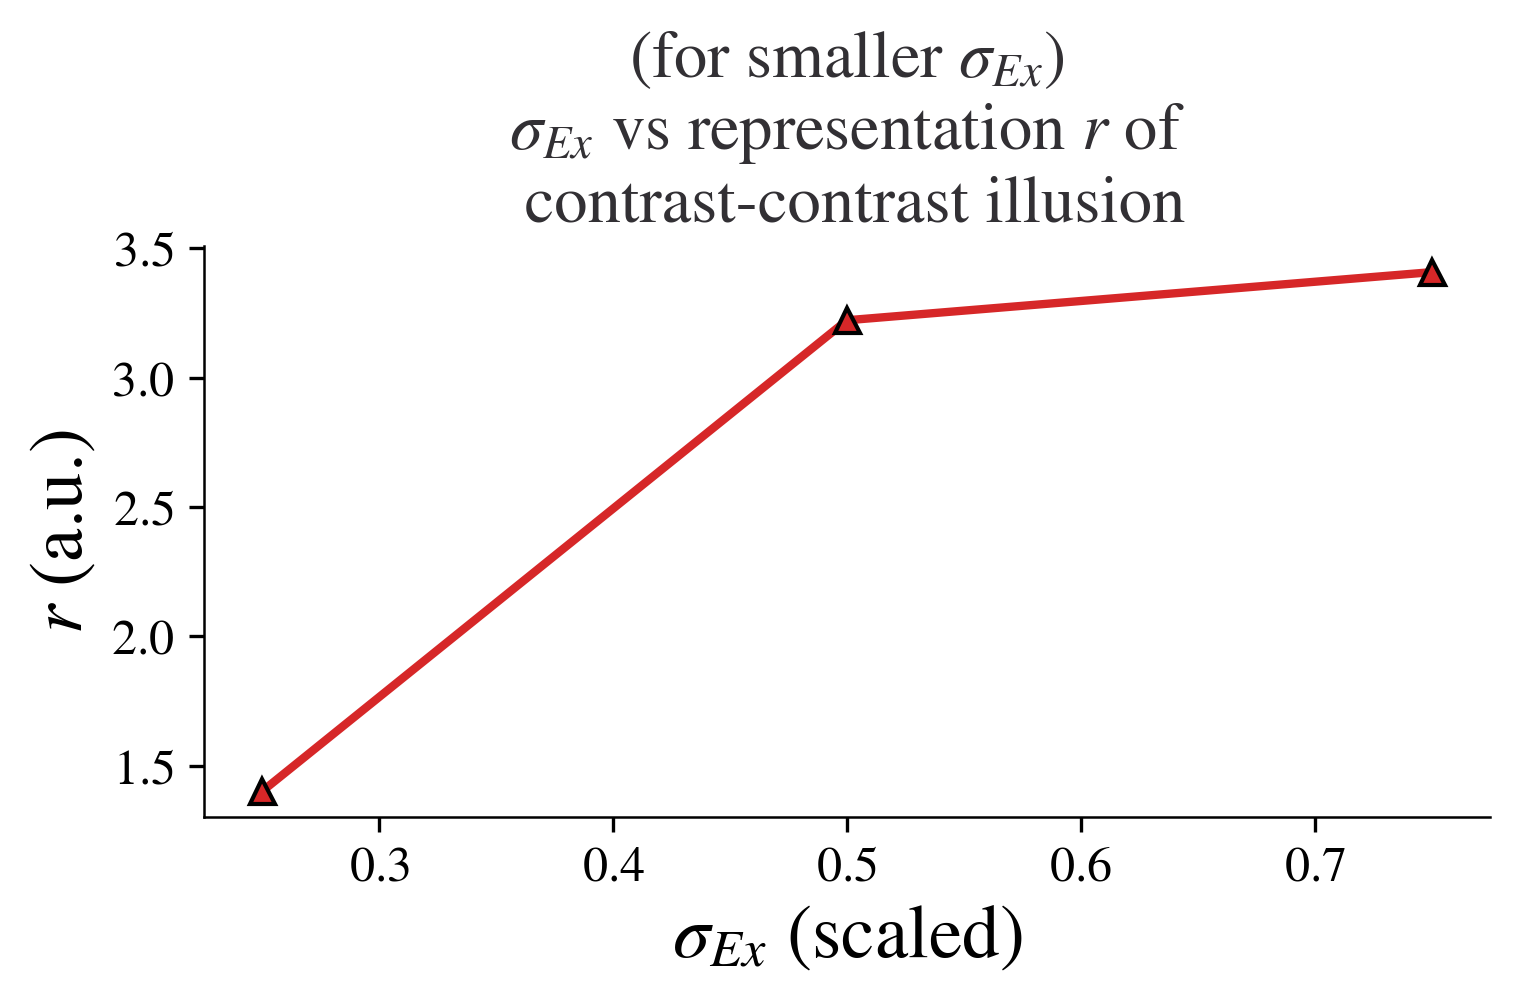

In [24]:

plt.figure(figsize=(s1, s2))

r_list= []
for i in range(0,3):
    plt.plot(np.arange(0,pixel_size,1),v1_exc_sigma_response_list[i][180,boundary_size:-boundary_size], 
             label=str(this_exc_list[i]))
    this_response = v1_exc_sigma_response_list[i][180,boundary_size:-boundary_size]

    mark_pos= int(2*input_scale*sr)
    win_left = this_response[mark_pos-300:mark_pos]
    win_left_st = np.argmax(win_left)
    win_left_ed = np.argmin(win_left) 
    
    if win_left_st<win_left_ed:
        r_surround= np.sum(np.abs(win_left[win_left_st:win_left_ed]))
    else:
        r_surround= np.sum(np.abs(win_left[win_left_ed:win_left_st]))
    
    
    win_right = this_response[mark_pos:mark_pos+50]
    
    win_right_st = np.argmax(win_right)
    win_right_ed = np.argmin(win_right) 
    
    if win_right_st>win_right_ed:
        r_center= np.sum(np.abs(win_left[win_right_ed:win_right_st]))
    else:
        r_center= np.sum(np.abs(win_left[win_right_st:win_right_ed]))
    print(i,":",r_surround)
    print(r_center)
    r_list.append(np.max(win_left)-np.min(win_right))

plt.xlabel('Position $i$')
plt.ylabel('Response (a.u.)')

plt.axvline(x=mark_pos+50,color='tab:purple')
plt.axvline(x=mark_pos+0,color='tab:red')

plt.legend(title='$\sigma_{Ex}$ (scaled)',loc='lower right',fontsize=12, title_fontsize=12)#,  bbox_to_anchor=(1, 0.5))

plt.xlim(mark_pos-300,mark_pos+400 )
plt.ylim([-3, 1.6])
plt.title('Spatial response $x^{L2}_{i}$  to \n the contrast-contrast stimulus', loc='center',fontsize=16 )


plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_sm_exc_sig_response.'+'png'), dpi=300)
with open(os.path.join(fig_save_path , 'cc_sm_exc_sig_response.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)
    


plt.figure(figsize=(s1, s2))

plt.plot(this_exc_list[:3],r_list,marker='^',c='tab:red')
plt.xlabel(r'$\sigma_{Ex}$ (scaled)')
plt.ylabel(r'$r$ (a.u.)')

plt.title('(for smaller $\sigma_{Ex}$)'+'\n' +
          r'$\sigma_{Ex}$ vs representation $r$ of'+ '\n contrast-contrast illusion', loc='center',fontsize=16)


plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_sm_exc_sig_rep.'+'png'), dpi=300)
with open(os.path.join(fig_save_path , 'cc_sm_exc_sig_rep.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)
    







In [25]:
this_inh_sig_list = [0.75,1,1.25,1.5,1.75,2]#,
this_exc_sig_list = [0.75,1,1.25,1.5]
combine_sigma_list = []
this_alpha=0.003*10
this_amp_exc= 0.4 /B 
this_amp_inh= 0.2 /C 

for v1_inh_sigma_scale in tqdm(this_inh_sig_list):
    exc_sigma_response_list = []
    for v1_exc_sigma_scale in tqdm(this_exc_sig_list):

        v1_sigma_Ex_scale = 1 * v1_exc_sigma_scale # *unit_2_scale
        v1_sigma_inh_scale =1 * v1_inh_sigma_scale   # *unit_2_scale
       
        this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
        this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
        this_v1_amp_inh = this_amp_inh*1 #v1_amp_scale
        this_v1_amp_exc = this_amp_exc*1

        X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_amp_exc  )
           

        this_X_vec = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
        this_X_vec_V1 = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
        this_X_vec_2nd = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
        this_X_vec_V1_2nd = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)

        
        exc_sigma_response_list.append (this_X_vec_V1_2nd)
        
    r_list = []    
    for i in range(len(this_exc_sig_list)): 
        this_response = exc_sigma_response_list[i][180,boundary_size:-boundary_size]
        mark_pos= int(2*input_scale*sr)
        win_left = this_response[mark_pos-300:mark_pos]
        win_left_st = np.argmax(win_left)
        win_left_ed = np.argmin(win_left) 

        if win_left_st<win_left_ed:
            r_surround= np.sum(np.abs(win_left[win_left_st:win_left_ed]))
        else:
            r_surround= np.sum(np.abs(win_left[win_left_ed:win_left_st]))


        win_right = this_response[mark_pos:mark_pos+50]

        win_right_st = np.argmax(win_right)
        win_right_ed = np.argmin(win_right) 

        if win_right_st>win_right_ed:
            r_center= np.sum(np.abs(win_left[win_right_ed:win_right_st]))
        else:
            r_center= np.sum(np.abs(win_left[win_right_st:win_right_ed]))
        print(i,":",r_surround)
        print(r_center)
        r_list.append(np.max(win_left)-np.min(win_right))

        
    
    combine_sigma_list.append(r_list)
        


0 : 18.993168528211072
1.8192592271812311
1 : 17.37552986007278
3.824900625313858
2 : 14.4801797400693
3.6830936082548584
3 : 12.290986374902465
2.4573812219088627
0 : 24.968485815564186
3.8396077404580233
1 : 24.172948682587066
5.9348763555375825
2 : 20.638239280490076
5.637762151172364
3 : 16.517302032022396
4.115298579550439
0 : 28.44722944389019
5.428857435098071
1 : 28.914715161220244
7.600007397586309
2 : 25.862018571660457
7.225852540274905
3 : 21.614698831845388
5.531723067065074
0 : 30.333935017517454
6.293396250023164
1 : 31.559322027901267
8.522545372979408
2 : 29.306938136466613
8.13245031388072
3 : 25.449673918971648
6.370822777925505
0 : 31.198578437960002
6.695941530185521
1 : 32.973862996515805
8.95750192870554
2 : 31.410237924043294
8.568642816634258
3 : 28.067058967249245
6.784557403374894
0 : 31.58146089543
6.848959957845324
1 : 33.76954149149635
9.124485886718105
2 : 32.58335303566231
8.737365543381264
3 : 29.569327392881455
6.945354639633515


# Figure 6A

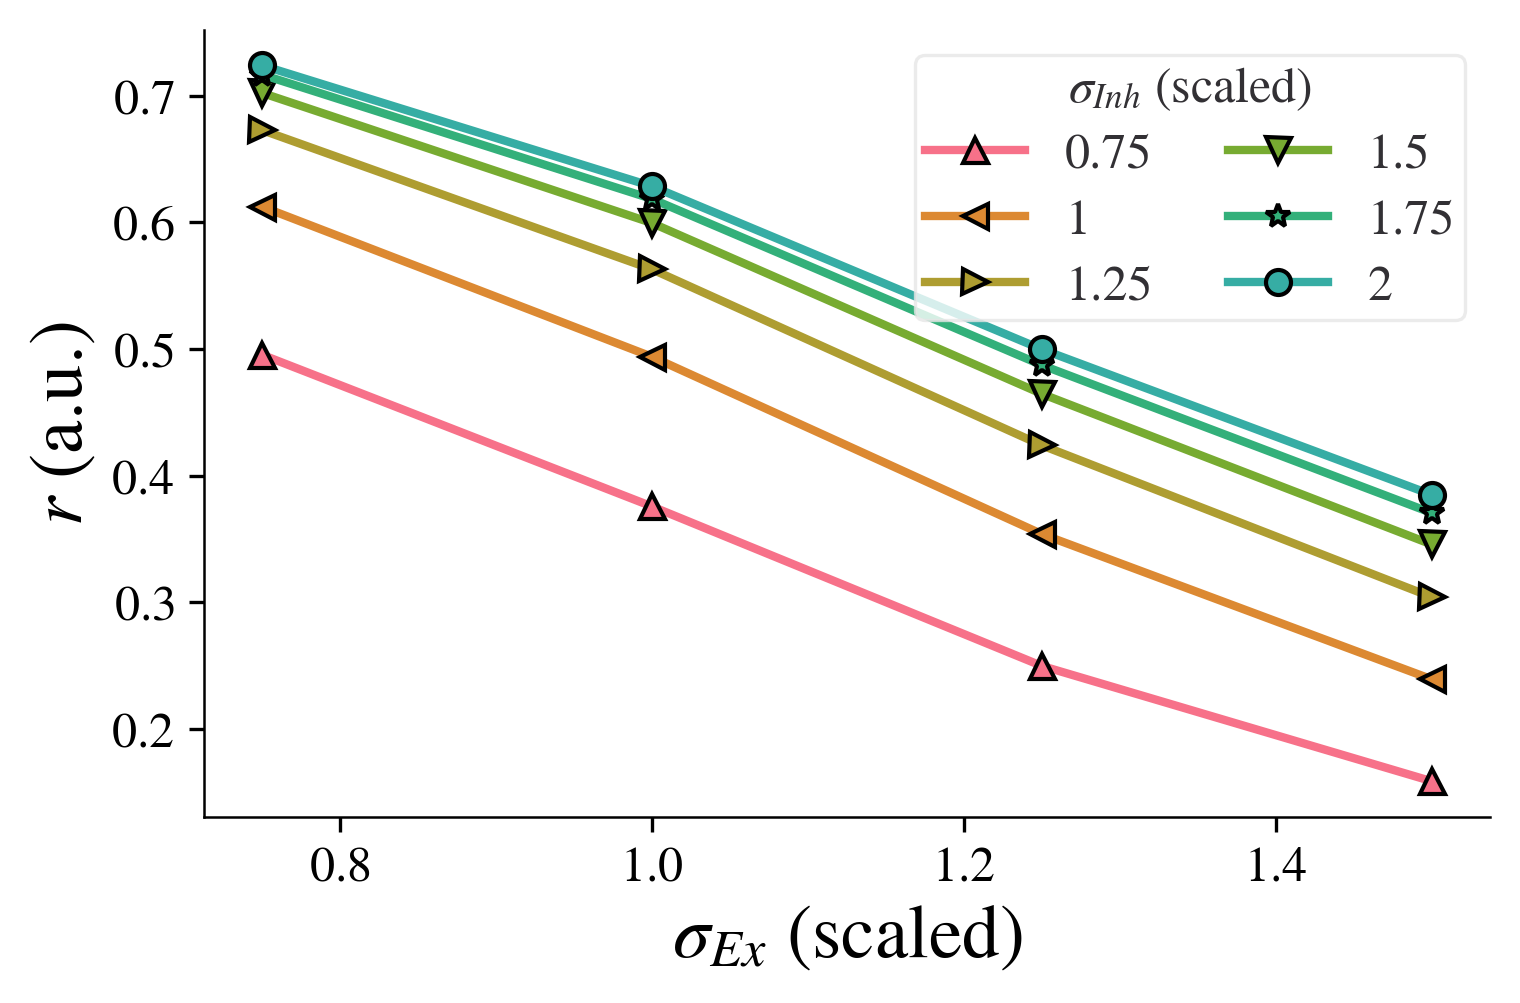

In [26]:
marker_list = ['^','<','>','v','*','o','+','1','2']
plt.figure(figsize=(s1, s2))
for i in range(len(this_inh_sig_list)):                           
        plt.plot(this_exc_sig_list,np.array(combine_sigma_list)[i],label=str(this_inh_sig_list[i]),marker=marker_list[i])
  
    
plt.xlabel(r'$\sigma_{Ex}$ (scaled)')
plt.ylabel('$r$ (a.u.)')

plt.legend(title=r"$\sigma_{Inh}$ (scaled)", loc='upper right', ncol=2,fontsize=12, title_fontsize=12)#, bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_sig_combine.'+'png'), dpi=300)
with open(os.path.join(fig_save_path , 'cc_sig_combine.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)
    



## Feedback

In [27]:
this_exc_sig_list =[0.75,1,1.25,1.5]#,1.75,2]#,
this_alpha_list = np.array([0.003,0.002,0.001,0])*a_scale
alpha_and_exc_list = []
this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23

for v1_exc_sigma_scale in tqdm(this_exc_sig_list):
    alpha_response_list = []
    for this_alpha in tqdm(this_alpha_list):

        v1_sigma_Ex_scale = 1 * v1_exc_sigma_scale # *unit_2_scale
        v1_sigma_inh_scale =1    # *unit_2_scale

        this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
        this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
        this_v1_amp_inh = this_amp_inh*1 #v1_amp_scale


        X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , 
                                                                            v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_amp_exc  )




        this_X_vec =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
        this_X_vec_V1 =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
        this_X_vec_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
        this_X_vec_V1_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)


        
        alpha_response_list.append (this_X_vec_V1_2nd)
        
    r_list = []    
    for i in range(len(this_alpha_list)): 
        
        this_response = alpha_response_list[i][180,boundary_size:-boundary_size]
        mark_pos= int(2*input_scale*sr)
        win_left = this_response[mark_pos-300:mark_pos]
        win_left_st = np.argmax(win_left)
        win_left_ed = np.argmin(win_left) 

        if win_left_st<win_left_ed:
            r_surround= np.sum(np.abs(win_left[win_left_st:win_left_ed]))
        else:
            r_surround= np.sum(np.abs(win_left[win_left_ed:win_left_st]))


        win_right = this_response[mark_pos:mark_pos+50]

        win_right_st = np.argmax(win_right)
        win_right_ed = np.argmin(win_right) 

        if win_right_st>win_right_ed:
            r_center= np.sum(np.abs(win_left[win_right_ed:win_right_st]))
        else:
            r_center= np.sum(np.abs(win_left[win_right_st:win_right_ed]))
        print(i,":",r_surround)
        print(r_center)
        r_list.append(np.max(win_left)-np.min(win_right))

        
    
    alpha_and_exc_list.append(r_list)
        

0 : 142.0878681804389
21.61863607647745
1 : 98.60985765247582
14.961744906694113
2 : 55.057690650353024
8.392251584645507
3 : 12.10588833313331
1.898965717328217
0 : 131.4066196824461
33.446120411221344
1 : 91.60398640557003
23.297685109403883
2 : 51.84868944733836
13.10477096673165
3 : 12.306988402033923
2.8516938976872592
0 : 103.41807000876375
29.137971348403145
1 : 72.77920418679
20.509113164258633
2 : 41.93278691455864
11.794383475208152
3 : 11.50531896257922
2.9840240467922694
0 : 74.35713330427635
18.70903263306657
1 : 52.7552681636968
13.36503387473004
2 : 31.441601301812447
7.950010794160296
3 : 10.211067582770365
2.4603400513978793


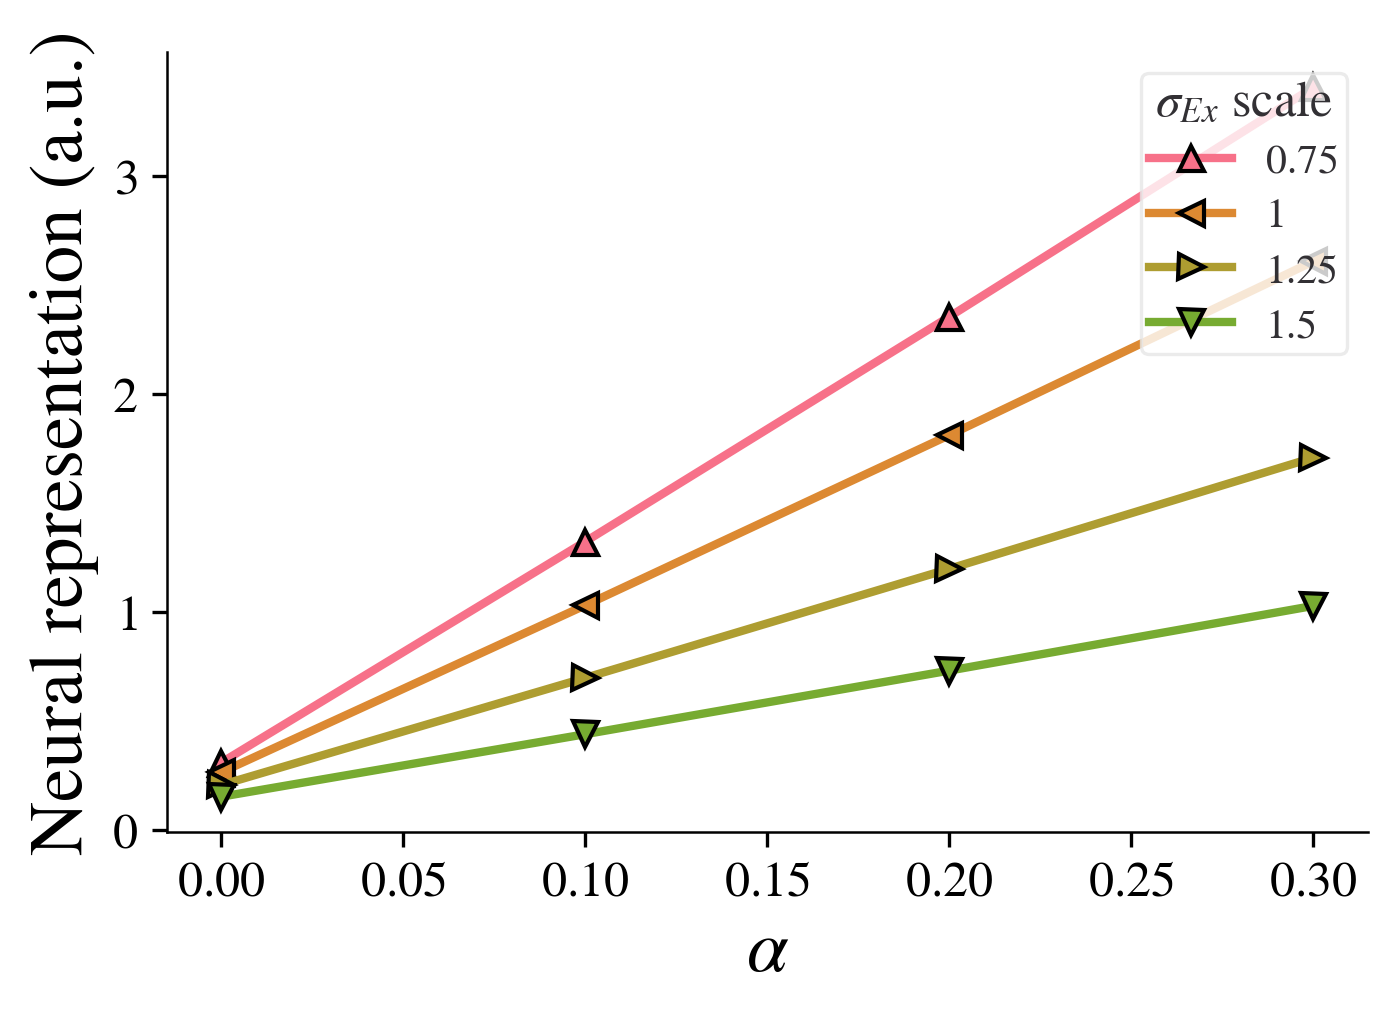

In [28]:

plt.figure(figsize=(s1, s2))

marker_list = ['^','<','>','v','*','o','+','1','2']
for i in range(len(this_exc_sig_list[:])):                           
        plt.plot(this_alpha_list,np.array(alpha_and_exc_list)[i,:],label=str(this_exc_sig_list[i]),marker=marker_list[i])
  
    
plt.xlabel(r'$\alpha$')
plt.ylabel('Neural representation (a.u.)')
plt.legend(title=r"$\sigma_{Ex}$ scale", loc='upper right')#, bbox_to_anchor=(1, 0.5))
with open(os.path.join(fig_save_path , 'cc_exc_al_rep.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)

In [29]:
this_inh_sig_list = [0.75,1,1.25,1.5,1.75,2]#,
this_inh_amp_list = [0.75,1,1.25,1.5,1.75]
combine_amp_list = []
this_alpha=0.003*10
this_amp_exc= 0.4 /B 
this_amp_inh= 0.2 /C 

for v1_inh_sigma_scale in tqdm(this_inh_sig_list):
    inh_amp_response_list = []
    for v1_inh_amp_scale in tqdm(this_inh_amp_list):
        v1_exc_sigma_scale=1
        v1_sigma_Ex_scale = 1 * v1_exc_sigma_scale # *unit_2_scale
        v1_sigma_inh_scale =1 * v1_inh_sigma_scale   # *unit_2_scale
        
        this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
        this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
        this_v1_amp_inh = this_amp_inh*v1_inh_amp_scale #v1_amp_scale
        this_v1_amp_exc = this_amp_exc*1

        X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_v1_amp_exc )
           

        this_X_vec = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
        this_X_vec_V1 = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
        this_X_vec_2nd = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
        this_X_vec_V1_2nd = net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)

        
        inh_amp_response_list.append (this_X_vec_V1_2nd)
        
    r_list = []    
    for i in range(len(this_inh_amp_list)): 
        
        this_response = inh_amp_response_list[i][180,boundary_size:-boundary_size]
        mark_pos= int(2*input_scale*sr)
        win_left = this_response[mark_pos-300:mark_pos]
        win_left_st = np.argmax(win_left)
        win_left_ed = np.argmin(win_left) 

        if win_left_st<win_left_ed:
            r_surround= np.sum(np.abs(win_left[win_left_st:win_left_ed]))
        else:
            r_surround= np.sum(np.abs(win_left[win_left_ed:win_left_st]))


        win_right = this_response[mark_pos:mark_pos+50]

        win_right_st = np.argmax(win_right)
        win_right_ed = np.argmin(win_right) 

        if win_right_st>win_right_ed:
            r_center= np.sum(np.abs(win_left[win_right_ed:win_right_st]))
        else:
            r_center= np.sum(np.abs(win_left[win_right_st:win_right_ed]))
        print(i,":",r_surround)
        print(r_center)
        r_list.append(np.max(win_left)-np.min(win_right))

        
    
    combine_amp_list.append(r_list)
        



0 : 20.94969280552024
4.899279573684439
1 : 17.37552986007278
3.824900625313858
2 : 14.361907200858223
2.8526195640593883
3 : 11.865982090625842
1.9821881085013549
4 : 9.842217994942684
1.2134300967150944
0 : 26.34122652145986
6.583003751492699
1 : 24.172948682587066
5.9348763555375825
2 : 22.223501756000843
5.321948279208122
3 : 20.652932274097893
4.744233354079091
4 : 19.246246077736437
4.201754098377253
0 : 30.127928433915955
7.877429130949951
1 : 28.914715161220244
7.600007397586309
2 : 27.785287317650827
7.32748837050797
3 : 26.72817712072778
7.059926165733165
4 : 25.732275797892886
6.797375149918656
0 : 32.25378031087828
8.584841882095585
1 : 31.559322027901267
8.522545372979408
2 : 30.897910928977986
8.454776520691684
3 : 30.265085208171264
8.381568146642316
4 : 29.88817935493291
8.302953326704612
0 : 33.52145171007739
8.915139119852542
1 : 32.973862996515805
8.95750192870554
2 : 32.671977734492934
8.991642184334518
3 : 32.38333408898018
9.017574862148098
4 : 32.1047515684241
9.

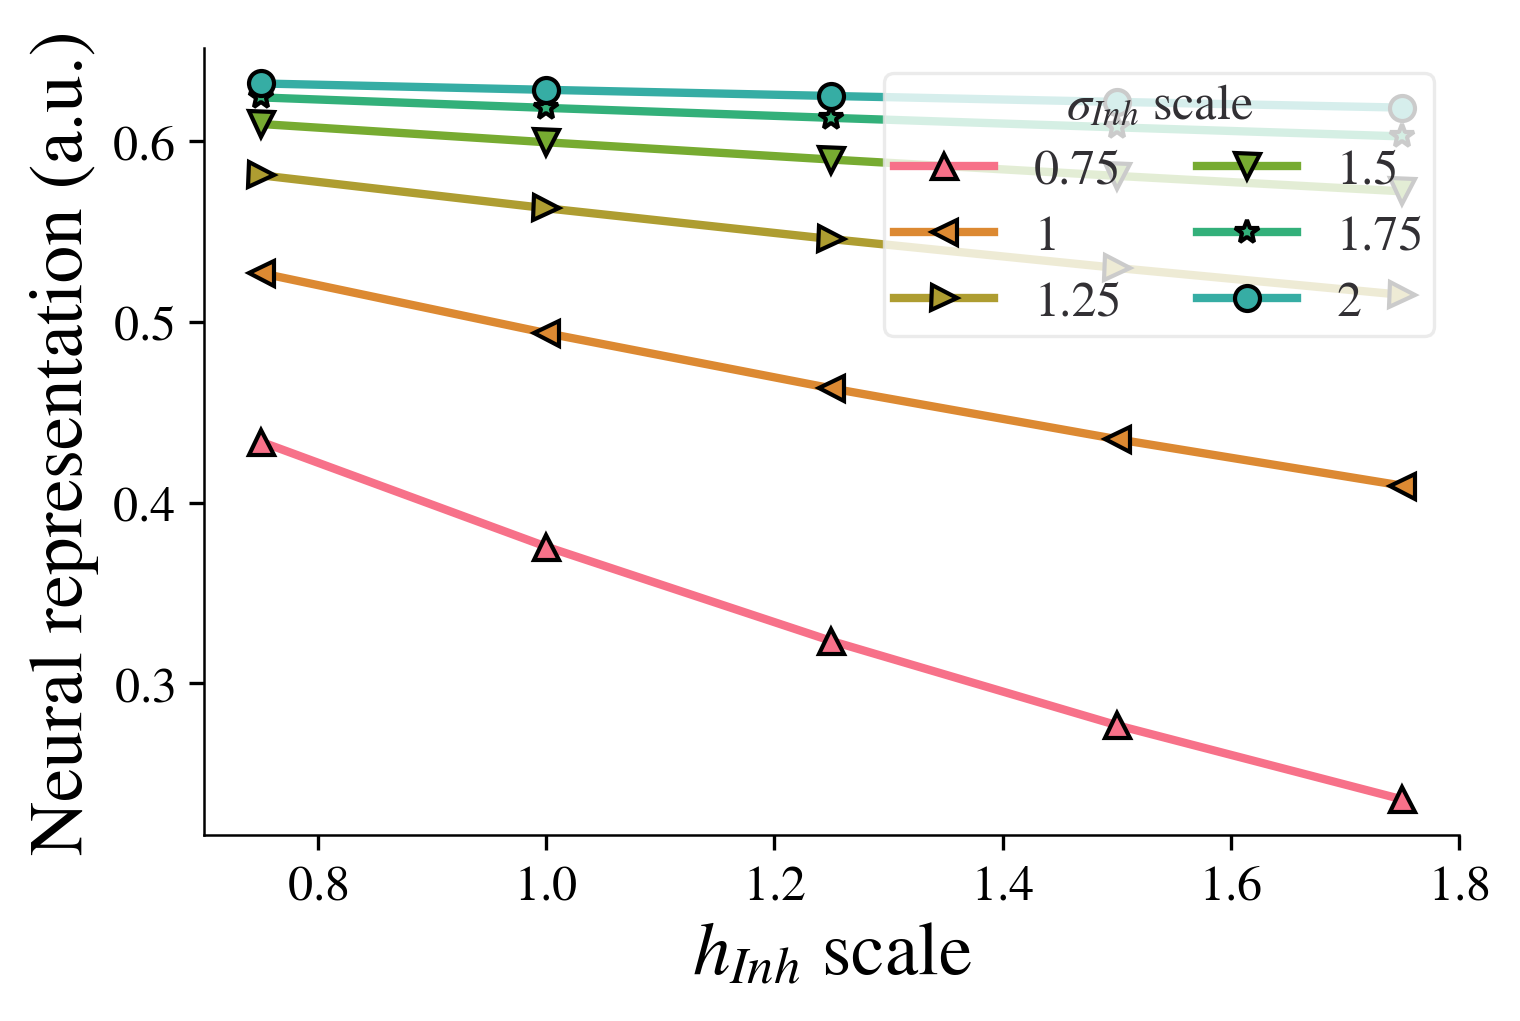

In [30]:
plt.figure(figsize=(s1, s2))
marker_list = ['^','<','>','v','*','o','+','1','2']
for i in range(len(this_inh_sig_list)):                           
        plt.plot(this_inh_amp_list,np.array(combine_amp_list)[i],label=str(this_inh_sig_list[i]),marker=marker_list[i])
  
    
plt.xlabel(r'$h_{Inh}$ scale')
plt.ylabel('Neural representation (a.u.)')

plt.legend(title=r"$\sigma_{Inh}$ scale", loc='upper right', ncol=2,fontsize=12, title_fontsize=12)#, bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_amp_combine.'+'png'), dpi=300)
with open(os.path.join(fig_save_path , 'cc_amp_combine.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)
    


